In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import io
from PIL import Image
import glob
import os
import pandas as pd
import matplotlib
#matplotlib.style.use('dark_background')
import re
import seaborn as sns
import scipy.io
import sys
from datetime import datetime, timedelta
sys.path.append('C:/Seafile/BSc_code/')
from functions import *
import h5py

In [2]:
# Main processing loop for multiple files
pc = 'sophia'
if pc == 'sophia':
    basevol='C:/Seafile/'
    basepath = basevol + '/BSc_data/'
    data_info = basepath + '/data_info/'
    output_folder = basepath + "/processed_data/"
    npz_directory = basepath + 'shark_tracking_data/'
    figures_path = basepath + "figures/"
    mat_file_path = basepath + 'carangids_manual_tracking/tracking/'
else:
    basevol = '/Users/ang/Seafile/'
    basepath = basevol + '/BSc_data/'
    data_info = basepath + '/data_info/'
    output_folder = basepath + "/processed_data/"
    npz_directory = basepath + 'shark_tracking_data/'
    figures_path = basepath + "figures/"
    mat_file_path = basepath + 'carangids_manual_tracking/tracking/'

In [3]:
midpoints = [('headx', 'heady'),('btipx', 'btipy'), ('pelvicfinx', 'pelvicfiny'), ('sdfinx', 'sdfiny'), ('pedunclex', 'peduncley'), ('finx','finy'), ('ttipx', 'ttipy')]
midpoints_centered = [('centered_headx', 'centered_heady'),('centered_btipx', 'centered_btipy'), ('centered_pelvicfinx', 'centered_pelvicfiny'), ('centered_sdfinx', 'centered_sdfiny'), ('centered_pedunclex', 'centered_peduncley'), ('centered_finx','centered_finy'), ('centered_ttipx', 'centered_ttipy')]
midpoints_rotated = [('rotated_headx', 'rotated_heady'),('rotated_btipx', 'rotated_btipy'), ('rotated_pelvicfinx', 'rotated_pelvicfiny'), ('rotated_sdfinx', 'rotated_sdfiny'), ('rotated_pedunclex', 'rotated_peduncley'), ('rotated_finx','rotated_finy'), ('rotated_ttipx', 'rotated_ttipy')]
joints_to_plot = [f'angle_joint_{i}' for i in range(6)]

### Load files

In [4]:
sharks_df = pd.read_hdf(output_folder + "kinematics_sharks.h5", key='sharks')

In [5]:
sharks_df.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0      0         0.000000   0          NaN          NaN -0.263183      0   
1      1        55.754349   0          NaN          NaN -0.253584      1   
2      2       103.976613   0          NaN          NaN -0.245468      2   
3      3       123.176350   0          NaN          NaN -0.238684      3   
4      4       126.865948   0          NaN          NaN -0.233522      4   

   time    headx       heady  ...  rotated_ttipy  normalized_nnd  \
0  0.00  2044.00  685.000000  ...      39.155948        0.754182   
1  0.01  2045.00  685.000000  ...      39.354319        0.751215   
2  0.02  2046.00  684.333333  ...      38.973346        0.751158   
3  0.03  2047.75  684.000000  ...      36.935070        0.747436   
4  0.04  2049.20  683.800000  ...      34.670463        0.743690   

   mean_body_length  body_length  standardized_speed  tailbeat_frequency  \
0        168.769768   177.037783                 NaN            1.020408   
1        168.968342   177.447051                 NaN            1.020408   
2        168.964560   177.425603                 NaN            1.020408   
3        169.092242   177.486965                 NaN            1.020408   
4        169.239818   176.966319                 NaN            1.020408   

   tailbeat_amplitude  standardized_amplitude  strouhal_number  Trial_num  
0           73.417593                0.414700              NaN          0  
1           73.417593                0.413744              NaN          0  
2           73.417593                0.413794              NaN          0  
3           73.417593                0.413651              NaN          0  
4           73.417593                0.414868              NaN          0  

[5 rows x 80 columns]

In [6]:
# sharks_df = pd.read_hdf(output_folder  + base_filename + "_sharks.h5", key='sharks')
df_sheets = pd.read_excel(data_info +'Sharkfilesworkingwith.xlsx',sheet_name=[2, 3])

In [7]:
df_present=df_sheets[2]
df_events=df_sheets[3]

In [8]:
# Initialize 'carangids' column to 0
sharks_df['events'] = 0

# Iterate through each row in df_events and apply conditions for each sequence
for _, row in df_events.iterrows():
    start = row['start_frame']
    sequence_name = row['sequence_name']  # The specific sequence from df_events
    event_value = row['events']  # Assuming 'event_value' column contains 'c', 's', or 'c+s'

    # Update the mask: Check frame range, ID match, and sequence name
    mask = (
        (sharks_df['frame'] >= (start - 50)) &  # Frame must be 50 or fewer frames before start
        (sharks_df['frame'] <= (start + 50)) &  # Frame must be 50 or fewer frames after start
        (sharks_df['Trial'] == sequence_name)   # Ensure matching sequence
    )

    # Apply the specific value to the 'events' column where the mask is True
    sharks_df.loc[mask, 'events'] = event_value

# Display the updated DataFrame
print(sharks_df[['frame', 'ID', 'events', 'Trial']])


C:\Users\sophi\AppData\Local\Temp\ipykernel_3804\3735921399.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'c' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sharks_df.loc[mask, 'events'] = event_value


        frame  ID events                                 Trial
0           0   0      0  sequence_20240303_060726300_DJI_0242
1           1   0      0  sequence_20240303_060726300_DJI_0242
2           2   0      0  sequence_20240303_060726300_DJI_0242
3           3   0      0  sequence_20240303_060726300_DJI_0242
4           4   0      0  sequence_20240303_060726300_DJI_0242
...       ...  ..    ...                                   ...
807042  32145   5      0  sequence_20240303_060726300_DJI_0242
807043  32146   5      0  sequence_20240303_060726300_DJI_0242
807044  32147   5      0  sequence_20240303_060726300_DJI_0242
807045  32148   5      0  sequence_20240303_060726300_DJI_0242
807046  32149   5      0  sequence_20240303_060726300_DJI_0242

[807047 rows x 4 columns]


In [9]:

# Define file filters
file_filters = ["*DJI_0139*", "*DJI_0305*", "*125_DJI_0266*", "*124_DJI_0266*", 
                "*DJI_0257*", "*DJI_0242*", "*DJI_0502*", "*DJI_0253*"]

# List to store all data
all_data = []

# Process each file matching filters
for file_filter in file_filters:
    search_pattern = os.path.join(mat_file_path, f"trackedPoints_sequence_*{file_filter}*.mat")
    files_list = np.sort(glob.glob(search_pattern, recursive=True))  # Enable recursive search
    
    # Skip if no files found
    if len(files_list) == 0:
        print(f"No files found for {file_filter}")
        continue

    for mat_file_path in files_list:
        print(f"Processing: {mat_file_path}")

        # Load .mat file
        mat_data = scipy.io.loadmat(mat_file_path)

        # Extract 'trackedPoints' field
        if 'trackedPoints' not in mat_data:
            print(f"'trackedPoints' not found in {mat_file_path}")
            continue

        tracked_points = mat_data['trackedPoints']

        # Extract base filename for reference
        filename_with_extension = os.path.basename(mat_file_path)
        filename = os.path.splitext(filename_with_extension)[0]

        # Iterate through the structure
        for point in tracked_points[0]:
            sequence_name = point[0][0]  # Extract sequence name
            frame_number = point[1][0][0]  # Extract frame number
            points_data = point[2][0]  # Extract chead and ctail arrays

            for object_index, chead_ctail in enumerate(points_data):
                chead = chead_ctail['chead']
                ctail = chead_ctail['ctail']

                if chead.ndim == 2 and ctail.ndim == 2:  # Ensure proper dimensions
                    for head, tail in zip(chead, ctail):
                        all_data.append({
                            'Trial': sequence_name,
                            'frame': frame_number,
                            'carangid_id': object_index,
                            'chead_x': head[0],
                            'chead_y': head[1],
                            'ctail_x': tail[0],
                            'ctail_y': tail[1],
                        })
                else:
                    print(f"Unexpected structure in {mat_file_path}: chead={chead}, ctail={ctail}")

# Convert list to DataFrame
carangids_df = pd.DataFrame(all_data)



No files found for *DJI_0139*
No files found for *DJI_0305*
Processing: C:/Seafile//BSc_data/carangids_manual_tracking/tracking\trackedPoints_sequence_20240303_072831125_DJI_0266_part_1.mat
Processing: C:/Seafile//BSc_data/carangids_manual_tracking/tracking\trackedPoints_sequence_20240303_072831125_DJI_0266_part_2.mat
No files found for *124_DJI_0266*
No files found for *DJI_0257*
No files found for *DJI_0242*
No files found for *DJI_0502*
No files found for *DJI_0253*


In [10]:
carangids_df.head()

Trial  frame  carangid_id      chead_x  \
0  sequence_20240303_072831125_DJI_0266   2400            0  1309.086759   
1  sequence_20240303_072831125_DJI_0266   2400            1  1297.506374   
2  sequence_20240303_072831125_DJI_0266   2425            0  1345.992357   
3  sequence_20240303_072831125_DJI_0266   2425            1  1331.624511   
4  sequence_20240303_072831125_DJI_0266   2450            0  1368.563215   

      chead_y      ctail_x    ctail_y  
0   44.708247  1285.526665  22.745447  
1   15.158299  1289.120578   1.181972  
2   84.466167  1318.796077  63.427535  
3   41.362629  1309.559605  21.350272  
4  113.200052  1352.408169  97.747399

### Nearest Neigbour

In [11]:
subset = pd.merge(sharks_df, carangids_df[['Trial', 'carangid_id', 'frame', 'chead_x', 'chead_y', 'ctail_x','ctail_y']], on=['Trial', 'frame'], how='left')

In [12]:
subset.groupby('Trial').count()

index  SPEED#wcentroid      ID  \
Trial                                                                   
sequence_20240303_060726300_DJI_0242  102358           102358  102358   
sequence_20240303_070126703_DJI_0257  104386           104386  104386   
sequence_20240303_072831125_DJI_0266  175123           175123  175123   
sequence_20240305_063615511_DJI_0253   91990            91990   91990   
sequence_20240305_070907124_DJI_0266   49489            49489   49489   
sequence_20240305_164039273_DJI_0305  120283           120283  120283   
sequence_20240306_161443984_DJI_0139   72936            72936   72936   
sequence_20240308_074843321_DJI_0502   91514            91514   91514   

                                      X#pcentroid  Y#pcentroid   ANGLE  \
Trial                                                                    
sequence_20240303_060726300_DJI_0242            0            0  102358   
sequence_20240303_070126703_DJI_0257            0            0       0   
sequence_20240303_072831125_DJI_0266       175123       175123  175123   
sequence_20240305_063615511_DJI_0253            0            0       0   
sequence_20240305_070907124_DJI_0266        49489        49489   49489   
sequence_20240305_164039273_DJI_0305       120283       120283  120283   
sequence_20240306_161443984_DJI_0139        72936        72936   72936   
sequence_20240308_074843321_DJI_0502            0            0   91514   

                                       frame    time   headx   heady  ...  \
Trial                                                                 ...   
sequence_20240303_060726300_DJI_0242  102358  102358  102358  102358  ...   
sequence_20240303_070126703_DJI_0257  104386  104386  104386  104386  ...   
sequence_20240303_072831125_DJI_0266  175123  175123  175120  175120  ...   
sequence_20240305_063615511_DJI_0253   91990   91990   91990   91990  ...   
sequence_20240305_070907124_DJI_0266   49489   49489   49489   49489  ...   
sequence_20240305_164039273_DJI_0305  120283  120283  120283  120283  ...   
sequence_20240306_161443984_DJI_0139   72936   72936   72936   72936  ...   
sequence_20240308_074843321_DJI_0502   91514   91514   91514   91514  ...   

                                      tailbeat_amplitude  \
Trial                                                      
sequence_20240303_060726300_DJI_0242              102358   
sequence_20240303_070126703_DJI_0257              104386   
sequence_20240303_072831125_DJI_0266              175123   
sequence_20240305_063615511_DJI_0253               91990   
sequence_20240305_070907124_DJI_0266               49489   
sequence_20240305_164039273_DJI_0305              120283   
sequence_20240306_161443984_DJI_0139               72936   
sequence_20240308_074843321_DJI_0502               91514   

                                      standardized_amplitude  strouhal_number  \
Trial                                                                           
sequence_20240303_060726300_DJI_0242                  102344           101438   
sequence_20240303_070126703_DJI_0257                  104386           103668   
sequence_20240303_072831125_DJI_0266                  175119           174317   
sequence_20240305_063615511_DJI_0253                   91990            91550   
sequence_20240305_070907124_DJI_0266                   49487            49189   
sequence_20240305_164039273_DJI_0305                  120283           119563   
sequence_20240306_161443984_DJI_0139                   72936            72736   
sequence_20240308_074843321_DJI_0502                   91514            90930   

                                      Trial_num  events  carangid_id  chead_x  \
Trial                                                                           
sequence_20240303_060726300_DJI_0242     102358  102358            0        0   
sequence_20240303_070126703_DJI_0257     104386  104386            0        0   
sequence_20240303_072831125_DJI_0266     175123  175123     

In [13]:

# Step 1: Initialize an empty DataFrame to collect results across sequences
all_results = pd.DataFrame()

# Iterate over each unique trial sequence
for trial in subset["Trial"].unique():
    # Filter the subset to the current trial
    trial_subset = subset[subset["Trial"] == trial]

    # Get unique fish (ID) and carangids (carangid_ID)
    fishlist = np.unique(trial_subset["ID"].dropna().values)  # Individual fish
    carangid_list = np.unique(trial_subset["carangid_id"].dropna().values)  # Carangids
    all_frames = np.unique(trial_subset["frame"].values)

    # Initialize results
    nearest_neighbors = []
    mindist = []

    # Step 2: Get coordinates for IDs and carangid_IDs
    fish_coords = trial_subset.groupby(["frame", "ID"])[["midpoint_x", "midpoint_y"]].mean().reset_index()
    carangid_coords = trial_subset.groupby(["frame", "carangid_id"])[["chead_x", "chead_y"]].mean().reset_index()

    # Step 3: Compute distances between each carangid_ID and all IDs per frame
    for frame in all_frames:
        frame_fish = fish_coords[fish_coords["frame"] == frame]
        frame_carangid = carangid_coords[carangid_coords["frame"] == frame]

        for _, car_row in frame_carangid.iterrows():
            carangid = car_row["carangid_id"]
            car_x, car_y = car_row["chead_x"], car_row["chead_y"]

            min_distance = np.inf
            nearest_id = None

            for _, fish_row in frame_fish.iterrows():
                fish = fish_row["ID"]
                fish_x, fish_y = fish_row["midpoint_x"], fish_row["midpoint_y"]

                # Compute Euclidean distance
                distance = np.sqrt((car_x - fish_x) ** 2 + (car_y - fish_y) ** 2)

                # Update nearest neighbor
                if distance < min_distance:
                    min_distance = distance
                    nearest_id = fish

            # Store results
            nearest_neighbors.append([carangid, frame, nearest_id, min_distance, trial])

    # Convert results to DataFrame
    trial_results_df = pd.DataFrame(
        nearest_neighbors, columns=["carangid_id", "frame", "nearest_neighbor_c", "nn_distance_c", "Trial"]
    )

     # Step 7: If nn_distance is NaN, also set nearest_neighbor to NaN
    trial_results_df.loc[trial_results_df["nn_distance_c"].isna(), "nearest_neighbor_c"] = np.nan

    # Append results for this trial
    all_results = pd.concat([all_results, trial_results_df], ignore_index=True)

# Drop any existing 'nearest_neighbor' and 'nn_distance' columns before merging
subset = subset.drop(columns=["nearest_neighbor_c", "nn_distance_c"], errors="ignore")

# Step 7: Merge all_results back into subset
subset = pd.merge(subset, all_results, on=["carangid_id", "frame", "Trial"], how="left")

# Display the result
print(subset)


C:\Users\sophi\AppData\Local\Temp\ipykernel_3804\47921214.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, trial_results_df], ignore_index=True)
C:\Users\sophi\AppData\Local\Temp\ipykernel_3804\47921214.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, trial_results_df], ignore_index=True)
C:\Users\sophi\AppData\Local\Temp\ipykernel_3804\47921214.py:58: FutureWarning: The behavior of DataFrame concatenation with e

         index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  \
0            0         0.000000   0          NaN          NaN -0.263183   
1            1        55.754349   0          NaN          NaN -0.253584   
2            2       103.976613   0          NaN          NaN -0.245468   
3            3       123.176350   0          NaN          NaN -0.238684   
4            4       126.865948   0          NaN          NaN -0.233522   
...        ...              ...  ..          ...          ...       ...   
808074  196702       130.516279   5          NaN          NaN  2.247529   
808075  196703       134.141083   5          NaN          NaN  2.245028   
808076  196704       128.902290   5          NaN          NaN  2.245964   
808077  196705       127.447305   5          NaN          NaN  2.247574   
808078  196706       127.507377   5          NaN          NaN  2.244495   

        frame        time     headx        heady  ...  strouhal_number  \
0           0    0.000000

In [14]:
subset.groupby('Trial').count()

index  SPEED#wcentroid      ID  \
Trial                                                                   
sequence_20240303_060726300_DJI_0242  102358           102358  102358   
sequence_20240303_070126703_DJI_0257  104386           104386  104386   
sequence_20240303_072831125_DJI_0266  175123           175123  175123   
sequence_20240305_063615511_DJI_0253   91990            91990   91990   
sequence_20240305_070907124_DJI_0266   49489            49489   49489   
sequence_20240305_164039273_DJI_0305  120283           120283  120283   
sequence_20240306_161443984_DJI_0139   72936            72936   72936   
sequence_20240308_074843321_DJI_0502   91514            91514   91514   

                                      X#pcentroid  Y#pcentroid   ANGLE  \
Trial                                                                    
sequence_20240303_060726300_DJI_0242            0            0  102358   
sequence_20240303_070126703_DJI_0257            0            0       0   
sequence_20240303_072831125_DJI_0266       175123       175123  175123   
sequence_20240305_063615511_DJI_0253            0            0       0   
sequence_20240305_070907124_DJI_0266        49489        49489   49489   
sequence_20240305_164039273_DJI_0305       120283       120283  120283   
sequence_20240306_161443984_DJI_0139        72936        72936   72936   
sequence_20240308_074843321_DJI_0502            0            0   91514   

                                       frame    time   headx   heady  ...  \
Trial                                                                 ...   
sequence_20240303_060726300_DJI_0242  102358  102358  102358  102358  ...   
sequence_20240303_070126703_DJI_0257  104386  104386  104386  104386  ...   
sequence_20240303_072831125_DJI_0266  175123  175123  175120  175120  ...   
sequence_20240305_063615511_DJI_0253   91990   91990   91990   91990  ...   
sequence_20240305_070907124_DJI_0266   49489   49489   49489   49489  ...   
sequence_20240305_164039273_DJI_0305  120283  120283  120283  120283  ...   
sequence_20240306_161443984_DJI_0139   72936   72936   72936   72936  ...   
sequence_20240308_074843321_DJI_0502   91514   91514   91514   91514  ...   

                                      strouhal_number  Trial_num  events  \
Trial                                                                      
sequence_20240303_060726300_DJI_0242           101438     102358  102358   
sequence_20240303_070126703_DJI_0257           103668     104386  104386   
sequence_20240303_072831125_DJI_0266           174317     175123  175123   
sequence_20240305_063615511_DJI_0253            91550      91990   91990   
sequence_20240305_070907124_DJI_0266            49189      49489   49489   
sequence_20240305_164039273_DJI_0305           119563     120283  120283   
sequence_20240306_161443984_DJI_0139            72736      72936   72936   
sequence_20240308_074843321_DJI_0502            90930      91514   91514   

                                      carangid_id  chead_x  chead_y  ctail_x  \
Trial                                                                          
sequence_20240303_060726300_DJI_0242            0        0        0        0   
sequence_20240303_070126703_DJI_0257            0        0        0        0   
sequence_20240303_072831125_DJI_0266         2514     2514     2514     2514   
sequence_20240305_063615511_DJI_0253            0        0        0        0   
sequence_20240305_070907124_DJI_0266            0        0        0        0   
sequence_20240305_164039273_DJI_0305            0        0        0        0   
sequence_20240306_161443984_DJI_0139            0        0        0        0   
sequence_20240308_074843321_DJI_0502            0        0        0        0   

                                      ctail_y  nearest_neighbor_c  \
Trial                                                               
sequence_20240303_060726300_DJI_0242        0                   0   
sequence_20240303_070126703

In [18]:
# Compute normalized NND using the mean smoothed body length for the frame
subset['normalized_nnd_c'] = subset['nn_distance_c'] / subset['mean_body_length']

subset.groupby('Trial').count()

index  SPEED#wcentroid      ID  \
Trial                                                                   
sequence_20240303_060726300_DJI_0242  102358           102358  102358   
sequence_20240303_070126703_DJI_0257  104386           104386  104386   
sequence_20240303_072831125_DJI_0266  175123           175123  175123   
sequence_20240305_063615511_DJI_0253   91990            91990   91990   
sequence_20240305_070907124_DJI_0266   49489            49489   49489   
sequence_20240305_164039273_DJI_0305  120283           120283  120283   
sequence_20240306_161443984_DJI_0139   72936            72936   72936   
sequence_20240308_074843321_DJI_0502   91514            91514   91514   

                                      X#pcentroid  Y#pcentroid   ANGLE  \
Trial                                                                    
sequence_20240303_060726300_DJI_0242            0            0  102358   
sequence_20240303_070126703_DJI_0257            0            0       0   
sequence_20240303_072831125_DJI_0266       175123       175123  175123   
sequence_20240305_063615511_DJI_0253            0            0       0   
sequence_20240305_070907124_DJI_0266        49489        49489   49489   
sequence_20240305_164039273_DJI_0305       120283       120283  120283   
sequence_20240306_161443984_DJI_0139        72936        72936   72936   
sequence_20240308_074843321_DJI_0502            0            0   91514   

                                       frame    time   headx   heady  ...  \
Trial                                                                 ...   
sequence_20240303_060726300_DJI_0242  102358  102358  102358  102358  ...   
sequence_20240303_070126703_DJI_0257  104386  104386  104386  104386  ...   
sequence_20240303_072831125_DJI_0266  175123  175123  175120  175120  ...   
sequence_20240305_063615511_DJI_0253   91990   91990   91990   91990  ...   
sequence_20240305_070907124_DJI_0266   49489   49489   49489   49489  ...   
sequence_20240305_164039273_DJI_0305  120283  120283  120283  120283  ...   
sequence_20240306_161443984_DJI_0139   72936   72936   72936   72936  ...   
sequence_20240308_074843321_DJI_0502   91514   91514   91514   91514  ...   

                                      Trial_num  events  carangid_id  chead_x  \
Trial                                                                           
sequence_20240303_060726300_DJI_0242     102358  102358            0        0   
sequence_20240303_070126703_DJI_0257     104386  104386            0        0   
sequence_20240303_072831125_DJI_0266     175123  175123         2514     2514   
sequence_20240305_063615511_DJI_0253      91990   91990            0        0   
sequence_20240305_070907124_DJI_0266      49489   49489            0        0   
sequence_20240305_164039273_DJI_0305     120283  120283            0        0   
sequence_20240306_161443984_DJI_0139      72936   72936            0        0   
sequence_20240308_074843321_DJI_0502      91514   91514            0        0   

                                      chead_y  ctail_x  ctail_y  \
Trial                                                             
sequence_20240303_060726300_DJI_0242        0        0        0   
sequence_20240303_070126703_DJI_0257        0        0        0   
sequence_20240303_072831125_DJI_0266     2514     2514     2514   
sequence_20240305_063615511_DJI_0253        0        0        0   
sequence_20240305_070907124_DJI_0266        0        0        0   
sequence_20240305_164039273_DJI_0305        0        0        0   
sequence_20240306_161443984_DJI_0139        0        0        0   
sequence_20240308_074843321_DJI_0502        0        0        0   

                                      nearest_neighbor_c  nn_distance_c  \
Trial                                                                     
sequence_20240303_060726300_DJI_0242                   0              0   
sequence_20240303_070126703_DJI_0257                   0              0   
sequence_20240

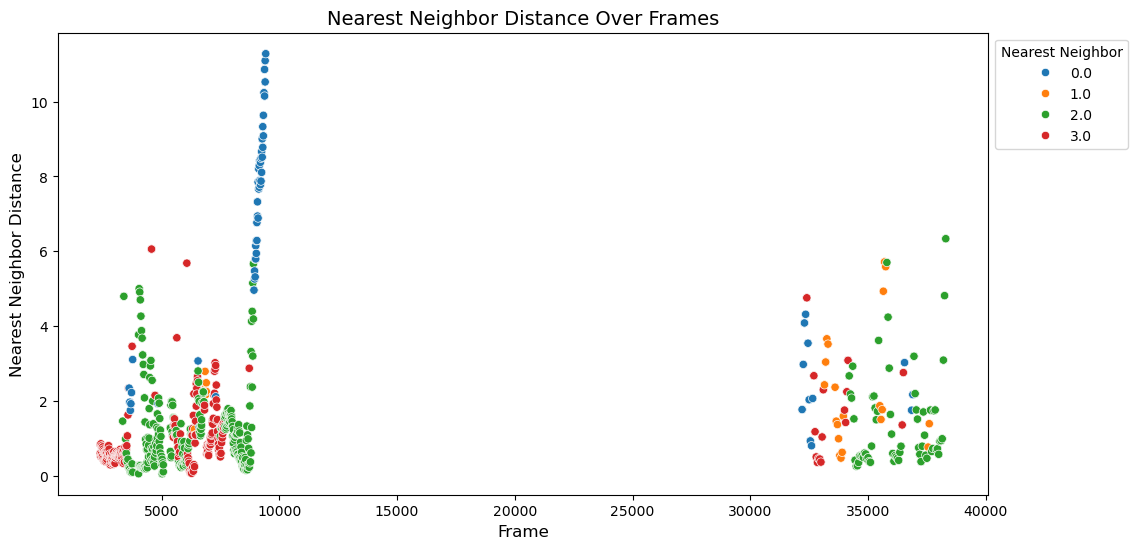

In [19]:

# Set figure size
plt.figure(figsize=(12, 6))

# Create lineplot
sns.scatterplot(data=subset, x="frame", y="normalized_nnd_c", hue="nearest_neighbor_c", palette="tab10", marker="o")

# Customize plot
plt.title("Nearest Neighbor Distance Over Frames", fontsize=14)
plt.xlabel("Frame", fontsize=12)
plt.ylabel("Nearest Neighbor Distance", fontsize=12)
plt.legend(title="Nearest Neighbor", bbox_to_anchor=(1, 1), loc="upper left")  # Move legend outside

# Show plot
plt.show()


### Heading

In [21]:
# Function to calculate the heading based on head and btip positions
# Function to calculate heading and angular velocity
def calculate_heading_and_angular_velocity(df, fps):
    """
    Calculate the heading angle and angular velocity based on headx, heady, and btipx, btipy.
    
    Heading is calculated as the arctangent of the slope formed by the line
    between the points (headx, heady) and (btipx, btipy).
    
    Angular velocity is calculated as the change in heading over time.

    Parameters:
    df (DataFrame): A pandas DataFrame that contains columns headx, heady, btipx, btipy.
    fps (int): Frames per second to calculate delta time (default is 30 FPS).
    
    Returns:
    DataFrame: The original DataFrame with new 'heading' and 'angular_velocity' columns.
    """
    # Calculate dx and dy for heading
    dx = df['chead_x'] - df['ctail_x']
    dy = df['chead_y'] - df['ctail_y']
    
    # Calculate heading in radians
    heading_radians = np.arctan2(dy, dx)
    
    # Add heading to the dataframe
    df['heading_c'] = heading_radians
    
    # Calculate delta heading (change in heading between consecutive points)
    df['delta_heading_c'] = df['heading_c'].diff()
    
    # Normalize delta_heading to handle wraparound (i.e., from -π to π)
    df['delta_heading_c'] = (df['delta_heading_c'] + np.pi) % (2 * np.pi) - np.pi
    
    # Calculate delta time (time between consecutive frames)
    df['delta_time_c'] = 1 / fps  # Assuming constant FPS
    
    # Calculate angular velocity (change in heading / delta time)
    df['angular_velocity_c'] = df['delta_heading_c'] / df['delta_time_c']
    
    # Drop intermediate columns (optional)
    df.drop(columns=['delta_time_c', 'delta_heading_c'], inplace=True)
    
    return df

# Function to calculate heading and angular velocity for each unique ID and segment
def calculate_heading_and_angular_velocity_per_id_segment(df, fps):
    """
    Calculate heading and angular velocity for each unique ID and segment.

    Parameters:
    df (DataFrame): A pandas DataFrame that contains columns headx, heady, btipx, btipy, ID, and segment.
    fps (int): Frames per second to calculate delta time.
    
    Returns:
    DataFrame: The original DataFrame with new 'heading' and 'angular_velocity' columns.
    """
    # Apply the heading and angular velocity calculation for each ID and segment
    df = df.groupby(['carangid_id', 'Trial']).apply(calculate_heading_and_angular_velocity, fps=fps).reset_index(drop=True)
    
    return df

subset = calculate_heading_and_angular_velocity_per_id_segment(subset, fps = 50)

C:\Users\sophi\AppData\Local\Temp\ipykernel_3804\3945407207.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['carangid_id', 'Trial']).apply(calculate_heading_and_angular_velocity, fps=fps).reset_index(drop=True)


In [22]:
subset.groupby('Trial').count()

index  SPEED#wcentroid    ID  \
Trial                                                                
sequence_20240303_072831125_DJI_0266   2514             2514  2514   

                                      X#pcentroid  Y#pcentroid  ANGLE  frame  \
Trial                                                                          
sequence_20240303_072831125_DJI_0266         2514         2514   2514   2514   

                                      time  headx  heady  ...  carangid_id  \
Trial                                                     ...                
sequence_20240303_072831125_DJI_0266  2514   2514   2514  ...         2514   

                                      chead_x  chead_y  ctail_x  ctail_y  \
Trial                                                                      
sequence_20240303_072831125_DJI_0266     2514     2514     2514     2514   

                                      nearest_neighbor_c  nn_distance_c  \
Trial                                                                     
sequence_20240303_072831125_DJI_0266                2514           2514   

                                      normalized_nnd_c  heading_c  \
Trial                                                               
sequence_20240303_072831125_DJI_0266              2514       2514   

                                      angular_velocity_c  
Trial                                                     
sequence_20240303_072831125_DJI_0266                2512  

[1 rows x 90 columns]

In [23]:
# Save sharks_df to HDF5
sharks_output_file = os.path.join(output_folder, "carangids_sharks.h5")
subset.to_hdf(sharks_output_file, key='sharks', mode='w')
print(f"Shark data saved to {sharks_output_file}")

Shark data saved to C:/Seafile//BSc_data//processed_data/carangids_sharks.h5


C:\Users\sophi\AppData\Local\Temp\ipykernel_3804\2902820021.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['frame', 'Trial', 'events'], dtype='object')]

  subset.to_hdf(sharks_output_file, key='sharks', mode='w')


### graphs

#### single frame

In [22]:
fil_subset = subset[(subset['ID'] == 3) & (subset['frame'] == 3000)]

In [23]:
fil_subset.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE frame  \
1137  144077        97.826616   3 -2738.950155 -1032.907359 -0.358064  3000   
2287  144077        97.826616   3 -2738.950155 -1032.907359 -0.358064  3000   

       time        headx  heady  ...      chead_x     chead_y      ctail_x  \
1137  59.89  2330.666667  639.5  ...  2257.827003  639.533039  2232.959677   
2287  59.89  2330.666667  639.5  ...  2231.315557  634.189646  2204.187565   

         ctail_y  nearest_neighbor_c  nn_distance_c  mean_body_length  \
1137  648.164672                 3.0      41.303555        129.173074   
2287  639.738554                 3.0      68.286793        129.173074   

      normalized_nnd_c  heading_c  angular_velocity_c  
1137          0.319754  -0.334096          -13.210480  
2287          0.528646  -0.201762          -11.211524  

[2 rows x 87 columns]

In [24]:
directions = fil_subset[['heading_c']].to_numpy()
#directions = np.deg2rad(angles)  # Convert to radians

# Generate random positions for arrows within a constrained range (0 to 20)
#positions = np.random.uniform(0, 20, size=(num_arrows, 2))
positions = fil_subset[['chead_x', 'chead_y']].to_numpy()

# Assign a specific orientation to the centroid
centroid_direction = fil_subset.groupby('frame')['heading'].mean()# Example orientation for the centroid
#centroid_direction = np.deg2rad(centroid_orientation)

# Calculate the centroid of the group
frame_centroids = fil_subset.groupby('frame')[['midpoint_x', 'midpoint_y']].mean()
centroid = frame_centroids.to_numpy()

# Center and rotate positions for the right plot
positions_centered = positions - centroid

# Calculate rotation matrix
rotation_matrix = np.array([
    [np.cos(-centroid_direction), -np.sin(-centroid_direction)],
    [np.sin(-centroid_direction), np.cos(-centroid_direction)]
])
positions_rotated = np.dot(positions_centered, rotation_matrix.T)
directions_rotated = directions - centroid_direction


ValueError: Length of values (2) does not match length of index (1)

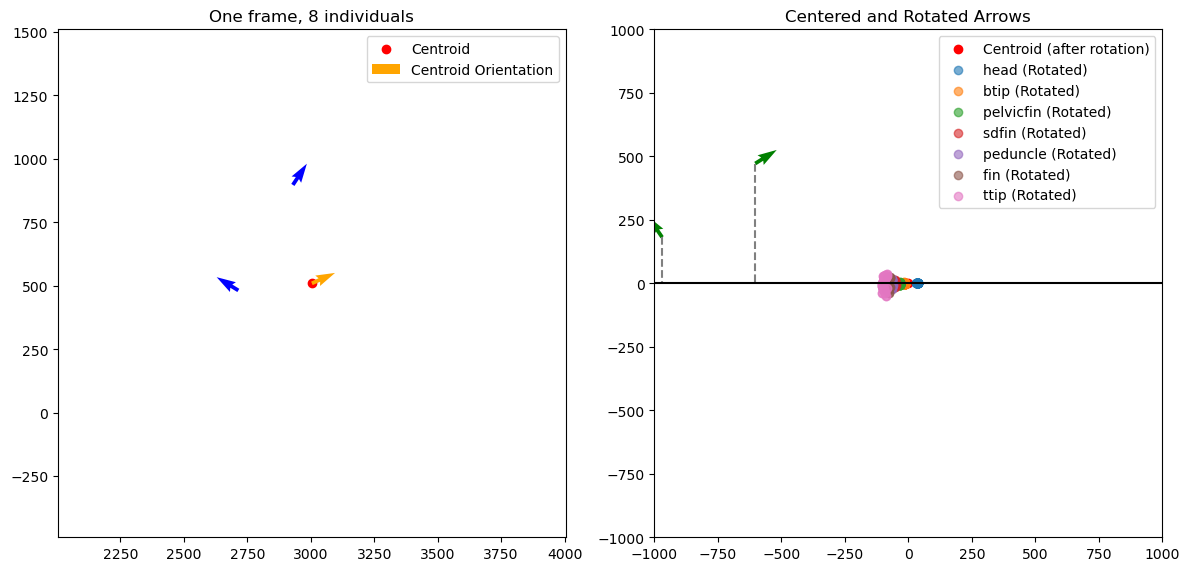

In [28]:
num_arrows = fil_subset['carangid_id'].nunique()
# Get the centroid (already calculated)
centroid = fil_subset[['midpoint_x', 'midpoint_y']].mean(axis=0).values

# List of body part columns
body_parts = ['head', 'btip', 'pelvicfin', 'sdfin', 'peduncle', 'fin', 'ttip']

# Calculate the size of the range you want around the centroid
range_size = 1000  # Adjust this value based on your data to determine how much space around the centroid to show

# Plot the arrows with dashed projections
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left plot: original arrows with diverse orientations
axes[0].quiver(positions[:, 0], positions[:, 1],
               np.cos(directions), np.sin(directions),
               angles='xy', scale_units='xy', scale=0.01, color='blue')
axes[0].scatter(centroid[0], centroid[1], color='red', label="Centroid")
axes[0].quiver(centroid[0], centroid[1],
               np.cos(centroid_direction), np.sin(centroid_direction),
               angles='xy', scale_units='xy', scale=0.01, color='orange', label="Centroid Orientation")
axes[0].set_title("One frame, 8 individuals")
axes[0].set_aspect('equal')
axes[0].legend()

# Right plot: centered and rotated arrows
axes[1].quiver(positions_rotated[:, 0], positions_rotated[:, 1],
               np.cos(directions_rotated), np.sin(directions_rotated),
               angles='xy', scale_units='xy', scale=0.01, color='green')
axes[1].scatter(0, 0, color='red', label="Centroid (after rotation)")

# Plot rotated body part points
for part in body_parts:
    axes[1].scatter(fil_subset[f'rotated_{part}x'], fil_subset[f'rotated_{part}y'], label=f"{part} (Rotated)", alpha=0.6)

# Draw dashed projections to y=0
for i in range(num_arrows):
    axes[1].plot([positions_rotated[i, 0], positions_rotated[i, 0]],
                 [positions_rotated[i, 1], 0], linestyle='--', color='gray')

axes[1].set_title("Centered and Rotated Arrows")
axes[1].set_aspect('equal')
axes[1].legend()
axes[1].axhline(y=0, color='k')

# Dynamically set axis limits based on the centroid's position
axes[0].set_xlim(centroid[0] - range_size, centroid[0] + range_size)
axes[0].set_ylim(centroid[1] - range_size, centroid[1] + range_size)
axes[1].set_xlim(-range_size, range_size)
axes[1].set_ylim(-range_size, range_size)

plt.tight_layout()
plt.show()


#### multiple frames

In [25]:
# fil_subset = subset[(subset['ID'] == 3) & (subset['frame'].between(3000,3800))]
# fil_subset = fil_subset.dropna(subset=['chead_x', 'chead_y'])
# # Initialize centroid and direction calculations by grouping by 'frame'
# frame_centroids = subset.groupby('frame')[['midpoint_x', 'midpoint_y']].mean()
# centroid_directions = subset.groupby('frame')['heading'].mean() ## of the shark

# # Create empty lists to store the results of rotated positions and directions
# rotated_positions_list = []
# rotated_directions_list = []

# # Loop through each unique frame in the 'fil_subset'
# for frame in subset['frame'].unique():
    
#     # Get the positions (chead_x, chead_y) for the current frame
#     positions = subset[subset['frame'] == frame][['chead_x', 'chead_y']].to_numpy()
    
#     # Get the directions (heading_c) for the current frame
#     directions = subset[subset['frame'] == frame][['heading_c']].to_numpy()

#     # Calculate the centroid for the current frame (midpoint_x, midpoint_y)
#     centroid = frame_centroids.loc[frame].values
    
#     # Get the centroid direction (heading) for the current frame
#     centroid_direction = centroid_directions.loc[frame]  # Mean heading for the current frame
    
#     # Center the positions by subtracting the centroid for the current frame
#     positions_centered = positions - centroid
    
#     # Calculate the rotation matrix based on the centroid direction
#     rotation_matrix = np.array([
#         [np.cos(-centroid_direction), -np.sin(-centroid_direction)],
#         [np.sin(-centroid_direction), np.cos(-centroid_direction)]
#     ])
    
#     # Rotate the positions for the current frame
#     positions_rotated = np.dot(positions_centered, rotation_matrix.T)
    
#     # Rotate the directions (same as positions) by subtracting the centroid direction
#     directions_rotated = directions - centroid_direction
    
#     # Append the results for each frame to the lists
#     rotated_positions_list.append(positions_rotated)
#     rotated_directions_list.append(directions_rotated)

# # Convert the lists to numpy arrays (if you need them in array form)
# rotated_positions = np.vstack(rotated_positions_list)
# rotated_directions = np.concatenate(rotated_directions_list)


In [24]:
subset['nearest_neighbor_c'] = subset['nearest_neighbor_c'].astype(int)
df_caranx_only = subset[subset['ID'] == subset['nearest_neighbor_c']].reset_index(drop=True)

In [25]:
### Calculate the rotation and centering according to the shark nearby

# Create new columns in the dataframe to store the rotated coordinates
df_caranx_only['chead_rotated_x'] = np.nan
df_caranx_only['chead_rotated_y'] = np.nan
df_caranx_only['ctail_rotated_x'] = np.nan
df_caranx_only['ctail_rotated_y'] = np.nan

# Loop over each unique frame
for frame in df_caranx_only['frame'].unique():
    # Create a mask for the current frame and extract its data
    frame_mask = df_caranx_only['frame'] == frame
    frame_data = df_caranx_only.loc[frame_mask]
    
    # Get the reference fish ID (nearest neighbor) for this frame.
    # (Assuming the 'nearest_neighbor_c' value is the same for all rows in the frame,
    #  or at least we use the first occurrence.)
    ref_id = frame_data['nearest_neighbor_c'].iloc[0]
    
    # Find the reference row: the fish with carangid_id equal to ref_id.
    ref_row = frame_data[frame_data['ID'] == ref_id]
    if ref_row.empty:
        print(f"Warning: In frame {frame} no fish with carangid_id {ref_id} was found. Skipping this frame.")
        continue
    ref_row = ref_row.iloc[0]
    
    # Get the reference midpoint and heading (assumed to be in radians)
    ref_midpoint = np.array([ref_row['midpoint_x'], ref_row['midpoint_y']])
    ref_heading = ref_row['heading']
    
    # Compute the rotation matrix using -ref_heading (to "align" the data)
    cos_val = np.cos(-ref_heading)
    sin_val = np.sin(-ref_heading)
    R = np.array([[cos_val, -sin_val],
                  [sin_val,  cos_val]])
    
    # For each fish in this frame, compute the rotated chead and ctail coordinates
    for idx, row in frame_data.iterrows():
        # Center the chead and ctail coordinates relative to the reference midpoint
        chead_coords = np.array([row['chead_x'], row['chead_y']]) - ref_midpoint
        ctail_coords = np.array([row['ctail_x'], row['ctail_y']]) - ref_midpoint
        
        # Rotate the centered coordinates using the rotation matrix R
        rotated_chead = R.dot(chead_coords)
        rotated_ctail = R.dot(ctail_coords)
        
        # Update the dataframe with the rotated coordinates
        df_caranx_only.loc[idx, 'chead_rotated_x'] = rotated_chead[0]
        df_caranx_only.loc[idx, 'chead_rotated_y'] = rotated_chead[1]
        df_caranx_only.loc[idx, 'ctail_rotated_x'] = rotated_ctail[0]
        df_caranx_only.loc[idx, 'ctail_rotated_y'] = rotated_ctail[1]

In [26]:
df_caranx_only

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE frame  \
0      8950       145.943583   0 -3152.835815  -831.362389  2.983212  8950   
1      8975       132.744720   0 -3217.419861  -813.493874  2.861747  8975   
2      9000       165.667625   0 -3271.587067  -795.756500  2.795991  9000   
3      9025       104.406062   0 -3312.422791  -769.127480  2.709408  9025   
4      9050       111.052249   0 -3349.943939  -743.716850  2.725031  9050   
..      ...              ...  ..          ...          ...       ...   ...   
630  148652       115.833403   3 -2186.302338 -1039.740097  2.723711  7575   
631  148677       105.024894   3 -2232.086609 -1023.135353  2.999104  7600   
632  148702       113.083234   3 -2289.556030 -1020.662376  2.694170  7625   
633  148727       131.883468   3 -2340.235443 -1002.236961  2.946211  7650   
634  149802       126.556059   3 -3101.344818  -455.310944 -0.587474  8725   

       time     headx     heady  ...      ctail_y  nearest_neighbor_c  \
0    178.93  1793.750   873.500  ...   753.881374                   0   
1    179.43  1732.125   898.000  ...   701.099766                   0   
2    179.93  1679.125   919.125  ...   645.457856                   0   
3    180.43  1636.625   953.250  ...   576.099766                   0   
4    180.93  1599.625   977.125  ...   521.550468                   0   
..      ...       ...       ...  ...          ...                 ...   
630  151.43  2757.375   682.250  ...   656.933533                   3   
631  151.93  2703.000   683.125  ...   609.559703                   3   
632  152.43  2653.875   704.250  ...   577.824532                   3   
633  152.93  2595.000   708.000  ...   603.898283                   3   
634  174.43  1961.375  1203.375  ...  1146.132284                   3   

     nn_distance_c  normalized_nnd_c  heading_c  angular_velocity_c  \
0       767.662736          5.474929  -2.381830           -0.434394   
1       807.732967          5.788173  -2.530867           -7.451840   
2       836.496001          6.145931  -2.227871           15.149771   
3       885.945955          6.279804  -2.677945          -22.503689   
4       946.785699          6.767585  -2.158799           25.957306   
..             ...               ...        ...                 ...   
630     181.007994          1.336692  -2.471954           -8.328146   
631     193.593680          1.383894  -2.729921          -12.898380   
632     185.782311          1.395128  -3.046641          -15.835982   
633     177.560648          1.267907  -2.930499            5.807081   
634     383.543523          2.872171   0.522058          -61.491541   

     chead_rotated_x  chead_rotated_y  ctail_rotated_x  ctail_rotated_y  
0         723.910521       255.459651       710.079553       236.947762  
1         696.933518       408.308973       679.615506       387.090619  
2         647.084493       530.101140       635.002067       494.613220  
3         592.352167       658.801295       569.765685       632.575417  
4         557.390699       765.322657       552.479356       735.236918  
..               ...              ...              ...              ...  
630      -174.089171       -49.566666      -185.924492       -72.268383  
631      -180.772927        69.279591      -223.973395        44.341924  
632      -180.726933        43.044658      -210.832380        25.934643  
633      -159.172286        78.689054      -194.887444        64.177157  
634       -79.160523      -650.317561      -120.806387       -63.137333  

[635 rows x 95 columns]

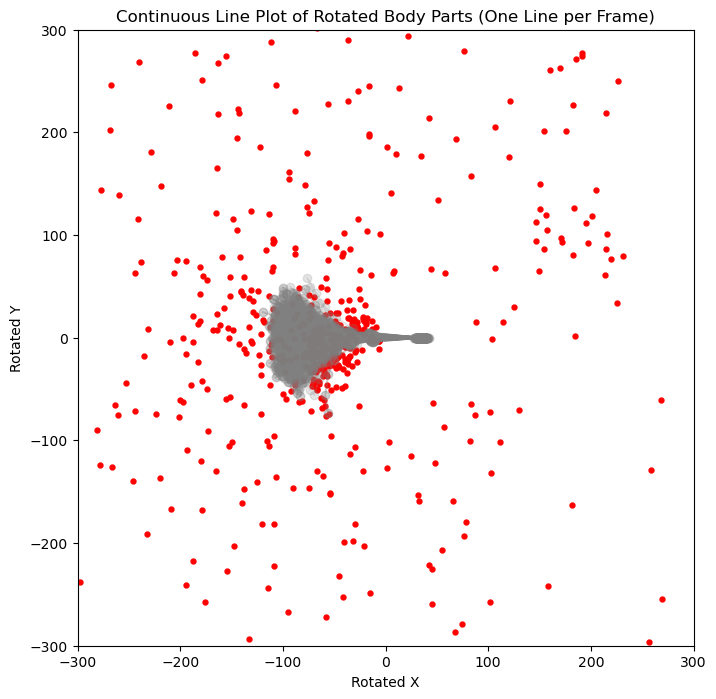

In [27]:
# Define the list of body parts in the order you want them connected.
body_parts = ['head', 'btip', 'pelvicfin', 'sdfin', 'peduncle', 'fin', 'ttip']

plt.figure(figsize=(8, 8))

# Loop over each unique frame in the dataframe.
for frame in df_caranx_only['frame'].unique():
    # Select the data for the current frame.
    frame_data = df_caranx_only[df_caranx_only['frame'] == frame]
    
    # For each fish (each row) in the frame, plot a continuous line.
    for i, row in frame_data.iterrows():
        xs = []
        ys = []
        for part in body_parts:
            # Construct the expected column names.
            x_col = f'rotated_{part}x'
            y_col = f'rotated_{part}y'
            
            # Check if the columns exist in the dataframe.
            if x_col in row and y_col in row:
                xs.append(row[x_col])
                ys.append(row[y_col])
            else:
                print(f"Warning: {x_col} or {y_col} not found for frame {frame}.")
        
        # Plot the line connecting the body parts.
        # Label only the first line from this frame for the legend.
        plt.plot(xs, ys, marker='o',
                 label=f"Frame {frame}" if i == frame_data.index[0] else None,alpha=0.2,color='grey')

# Overlay the rotated head positions from all frames.
plt.scatter(df_caranx_only['chead_rotated_x'], df_caranx_only['chead_rotated_y'], 
            color='red', marker='.', s=50, label='chead (Rotated)')

# Optionally, mark the origin for reference.
# plt.scatter(0, 0, color='black', zorder=5, label='Origin')

plt.title("Continuous Line Plot of Rotated Body Parts (One Line per Frame)")
plt.xlabel("Rotated X")
plt.ylabel("Rotated Y")

# Set dynamic axis limits.
range_size = 300
plt.xlim([-range_size, range_size])
plt.ylim([-range_size, range_size])
plt.gca().set_aspect('equal', adjustable='box')

# plt.legend()
plt.show()

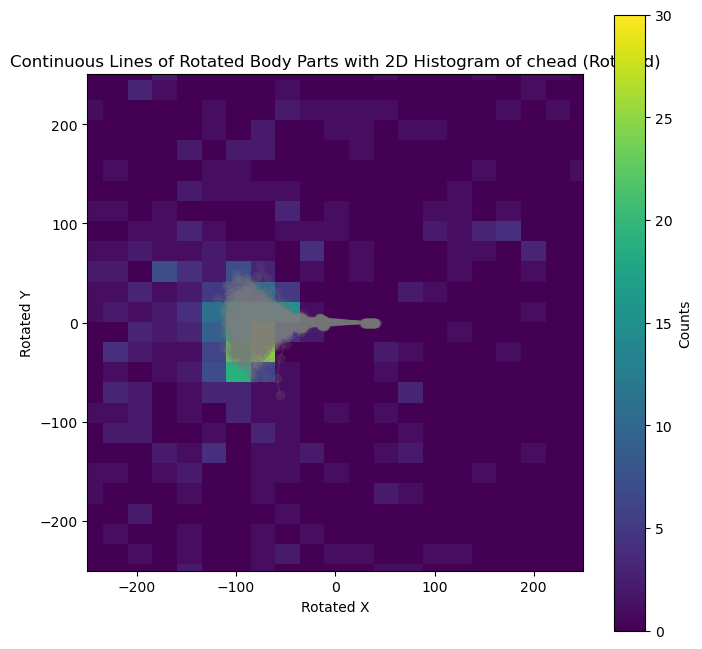

In [28]:
import matplotlib.pyplot as plt

# Define the list of body parts in the order you want them connected.
body_parts = ['head', 'btip', 'pelvicfin', 'sdfin', 'peduncle', 'fin', 'ttip']

plt.figure(figsize=(8, 8))

# Loop over each unique frame in the dataframe.
for frame in df_caranx_only['frame'].unique():
    # Select the data for the current frame.
    frame_data = df_caranx_only[df_caranx_only['frame'] == frame]
    
    # For each fish (each row) in the frame, plot a continuous line.
    for i, row in frame_data.iterrows():
        xs = []
        ys = []
        for part in body_parts:
            # Construct the expected column names.
            x_col = f'rotated_{part}x'
            y_col = f'rotated_{part}y'
            
            # Check if the columns exist in the row.
            if x_col in row and y_col in row:
                xs.append(row[x_col])
                ys.append(row[y_col])
            else:
                print(f"Warning: {x_col} or {y_col} not found for frame {frame}.")
        
        # Plot the line connecting the body parts.
        plt.plot(xs, ys, marker='o',
                 label=f"Frame {frame}" if i == frame_data.index[0] else None,
                 alpha=0.08, color='grey')

# Instead of overlaying a scatter plot, create a 2D histogram of the rotated chead positions.
hist = plt.hist2d(df_caranx_only['ctail_rotated_x'], df_caranx_only['ctail_rotated_y'], 
                  bins=100, cmap='viridis',vmin=0)

plt.title("Continuous Lines of Rotated Body Parts with 2D Histogram of chead (Rotated)")
plt.xlabel("Rotated X")
plt.ylabel("Rotated Y")

# Set dynamic axis limits.
range_size = 250
plt.xlim([-range_size, range_size])
plt.ylim([-range_size, range_size])
plt.gca().set_aspect('equal', adjustable='box')

# Add a colorbar to show the counts in the histogram.
plt.colorbar(hist[3], label='Counts')

plt.show()

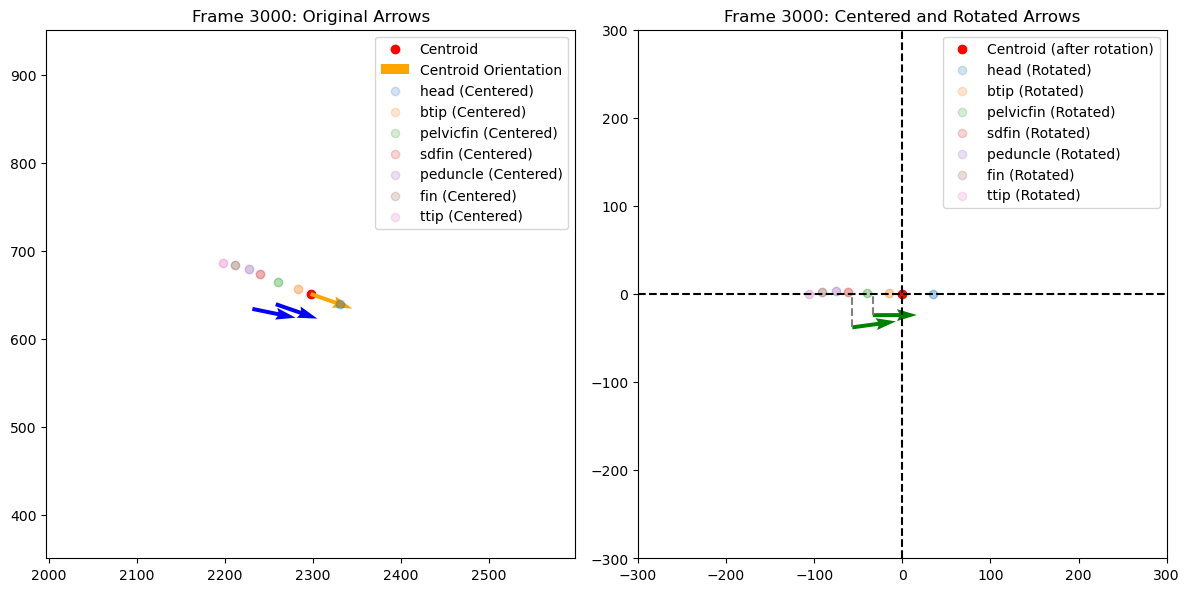

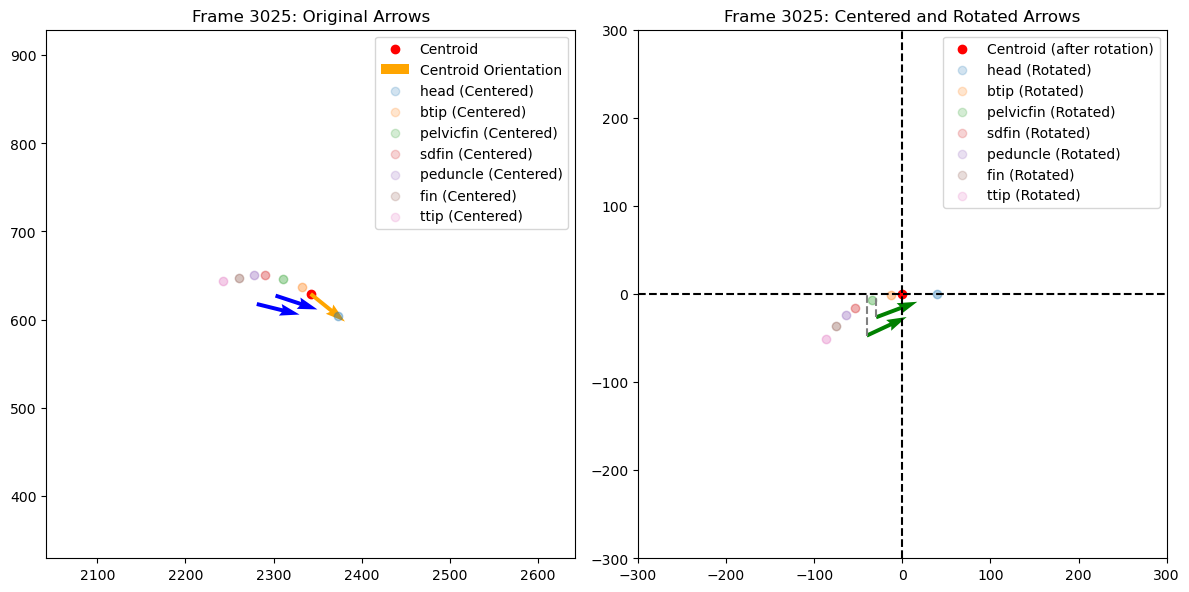

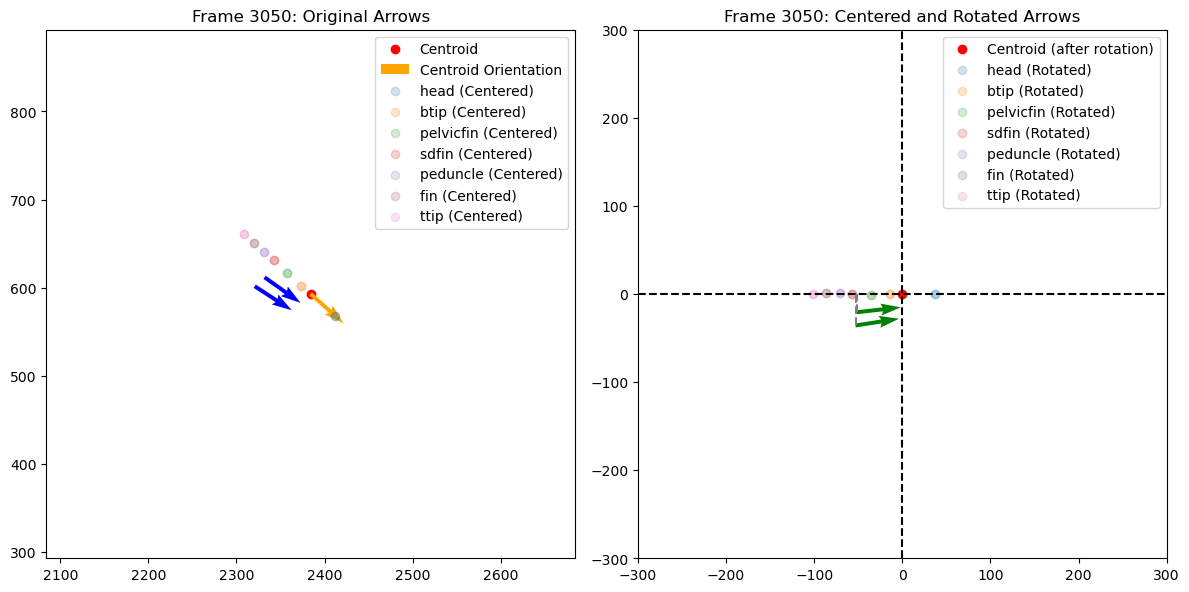

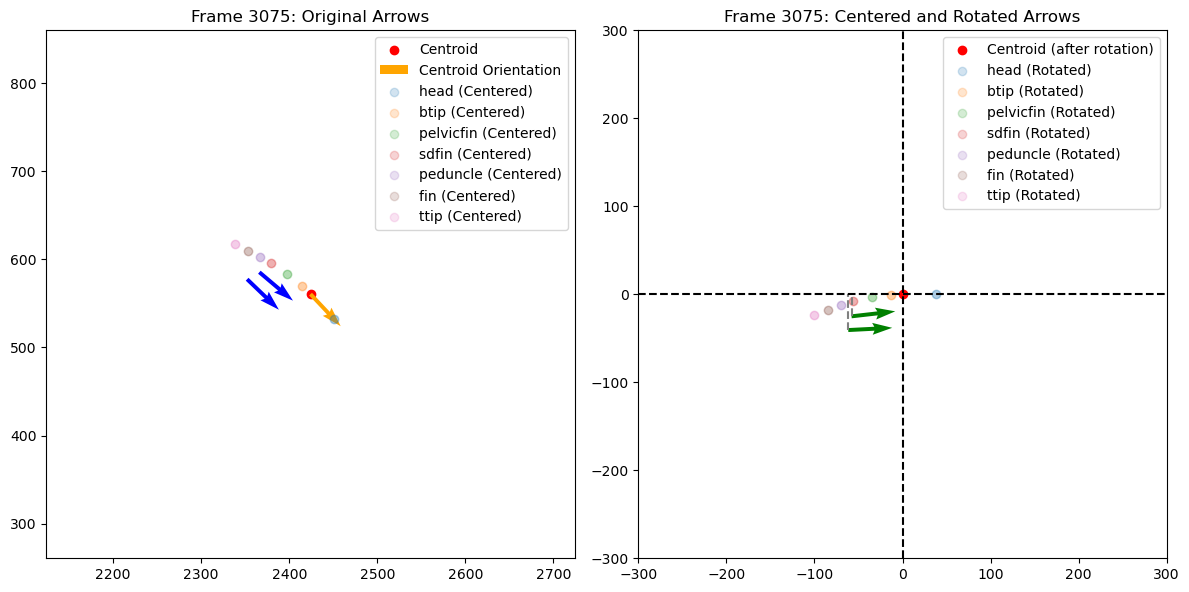

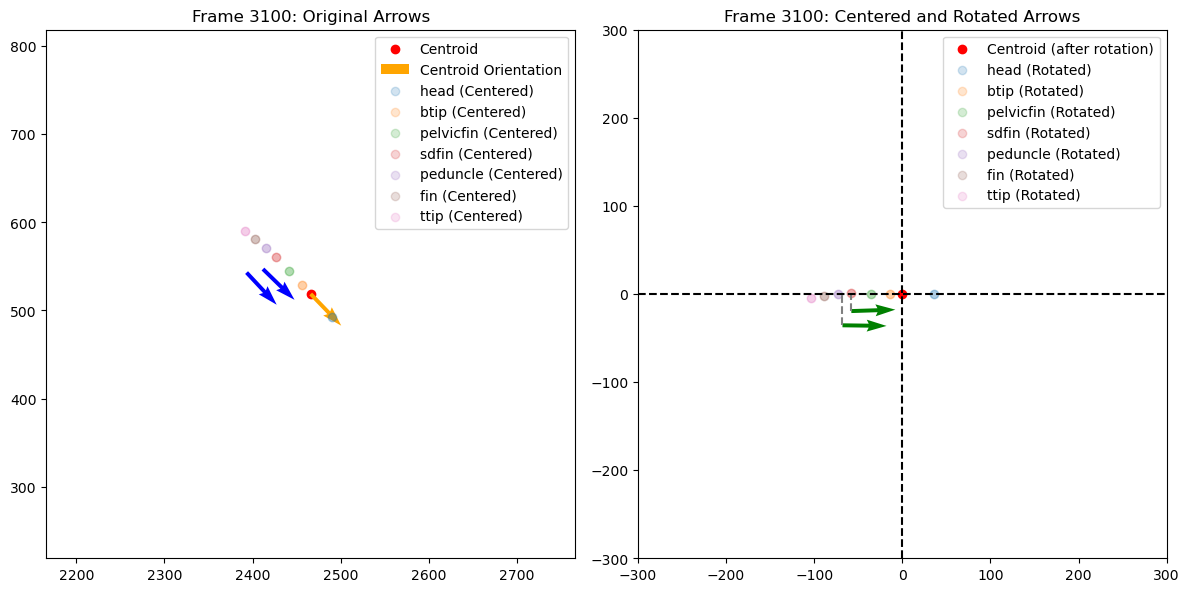

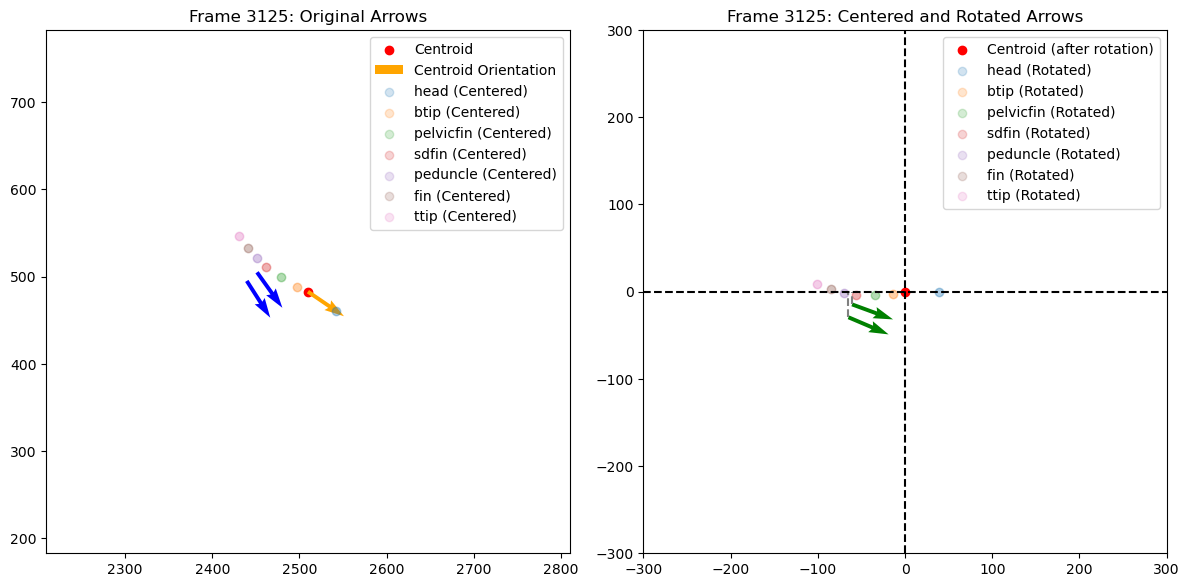

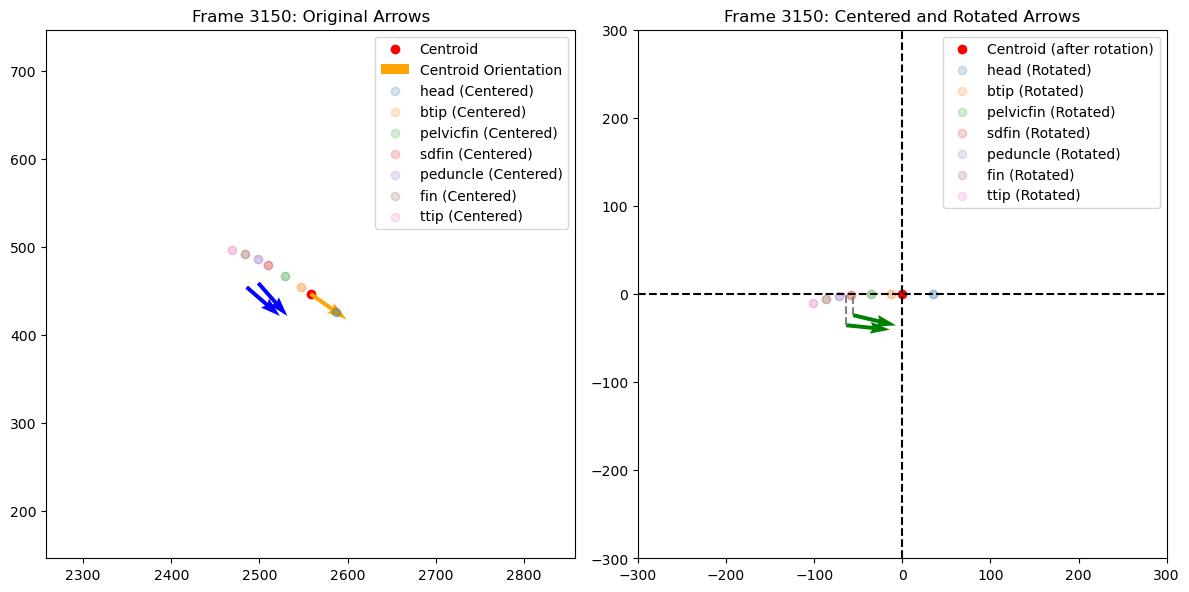

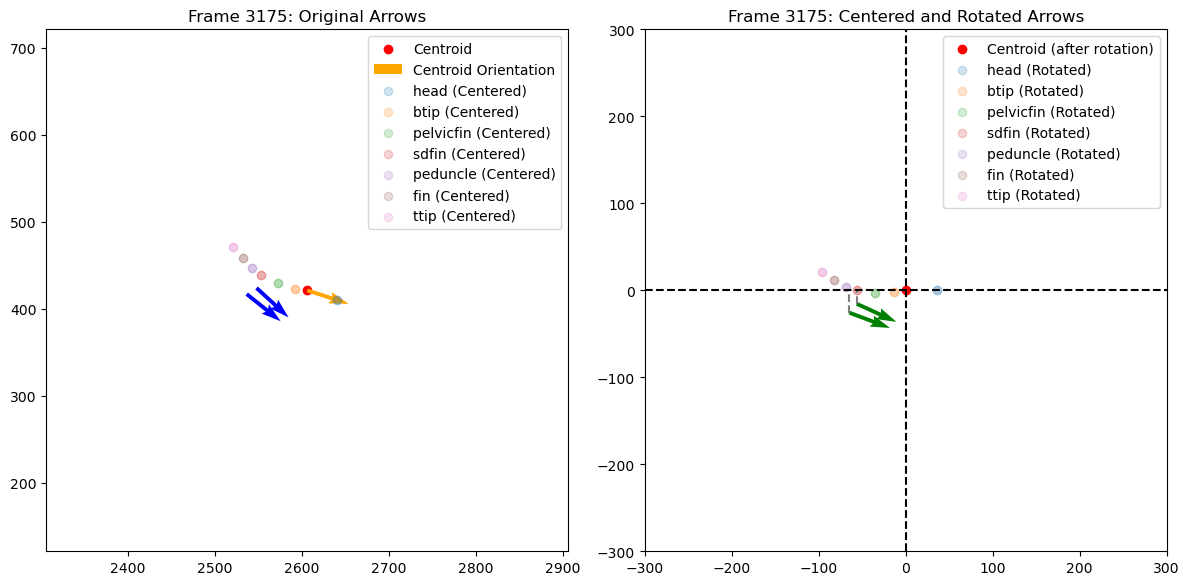

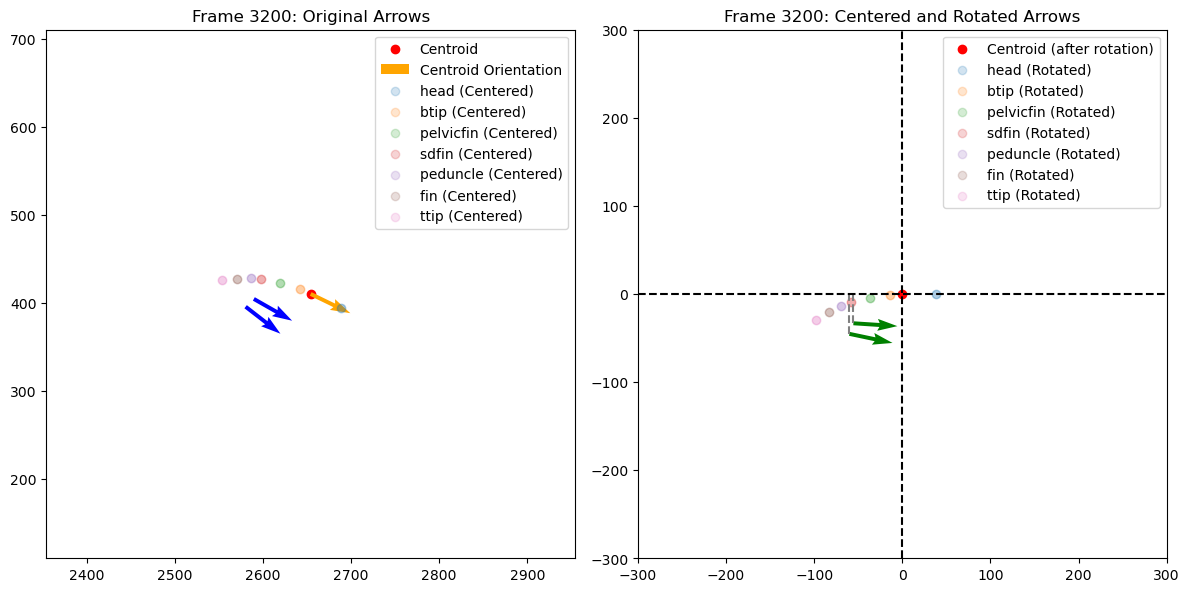

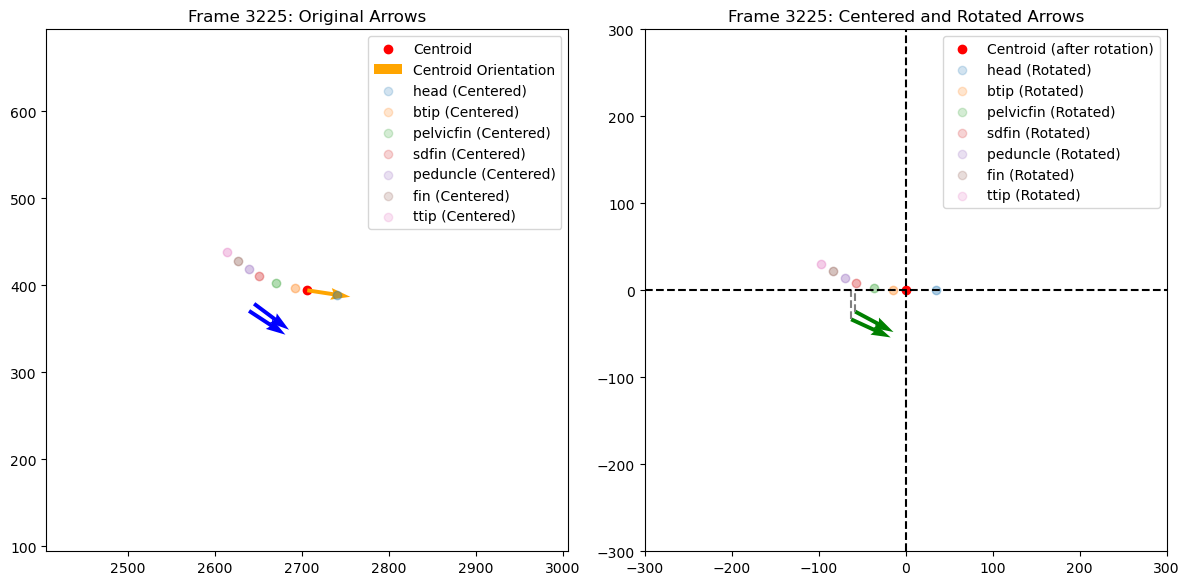

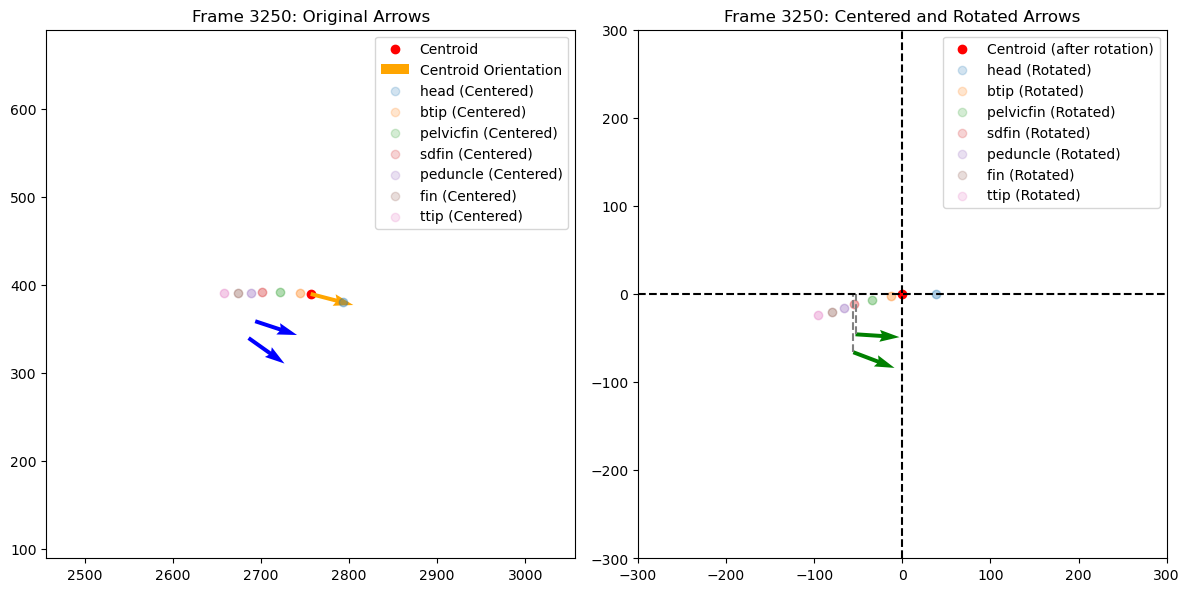

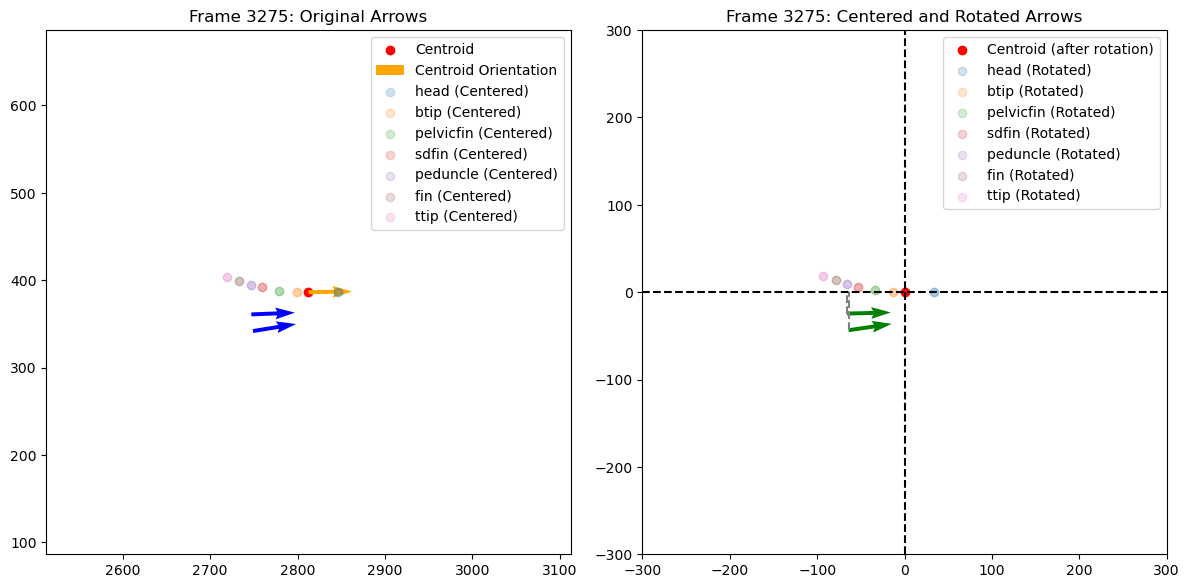

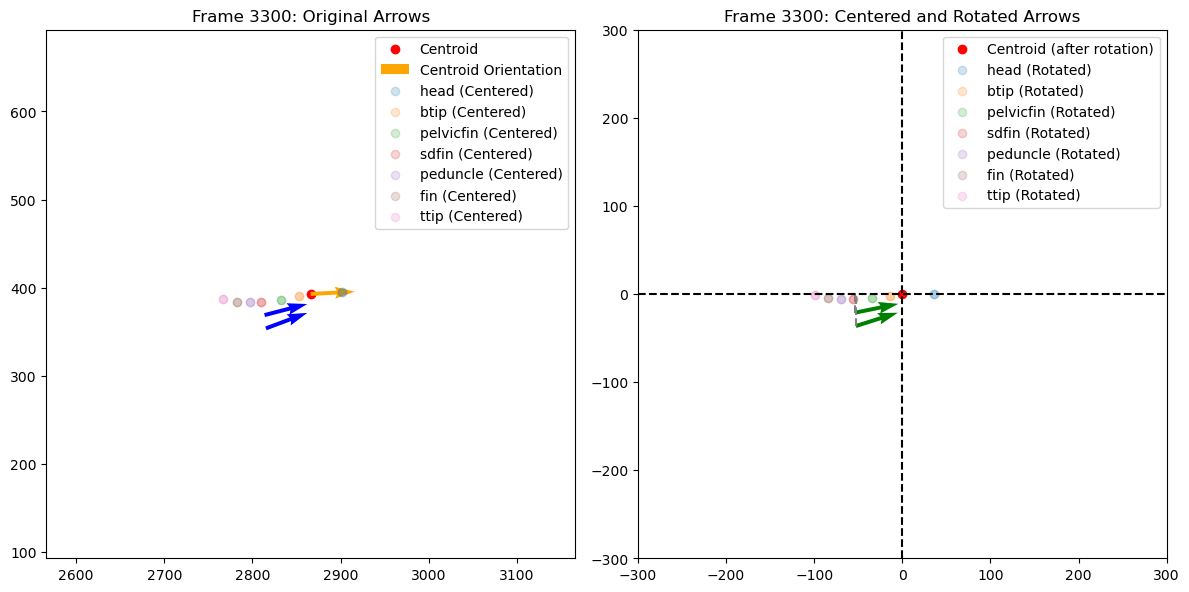

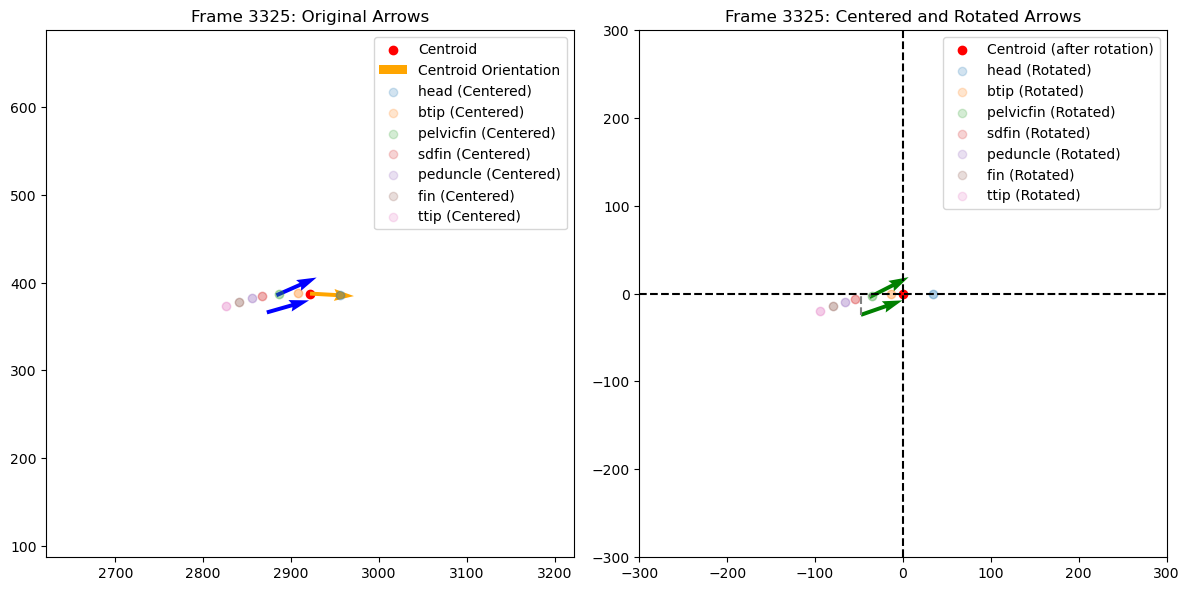

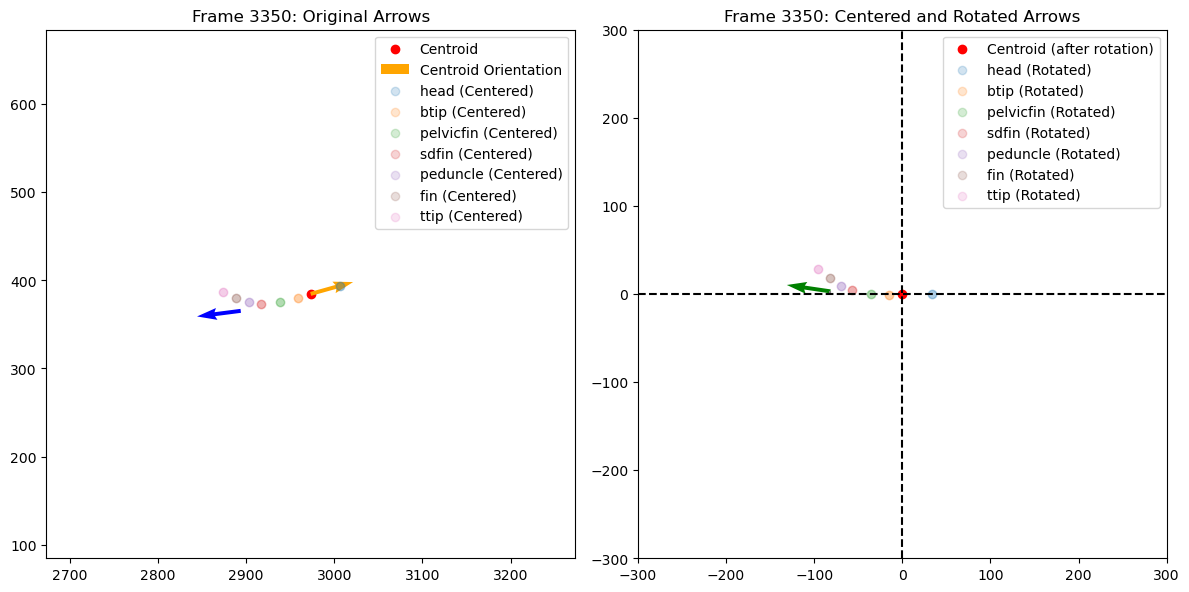

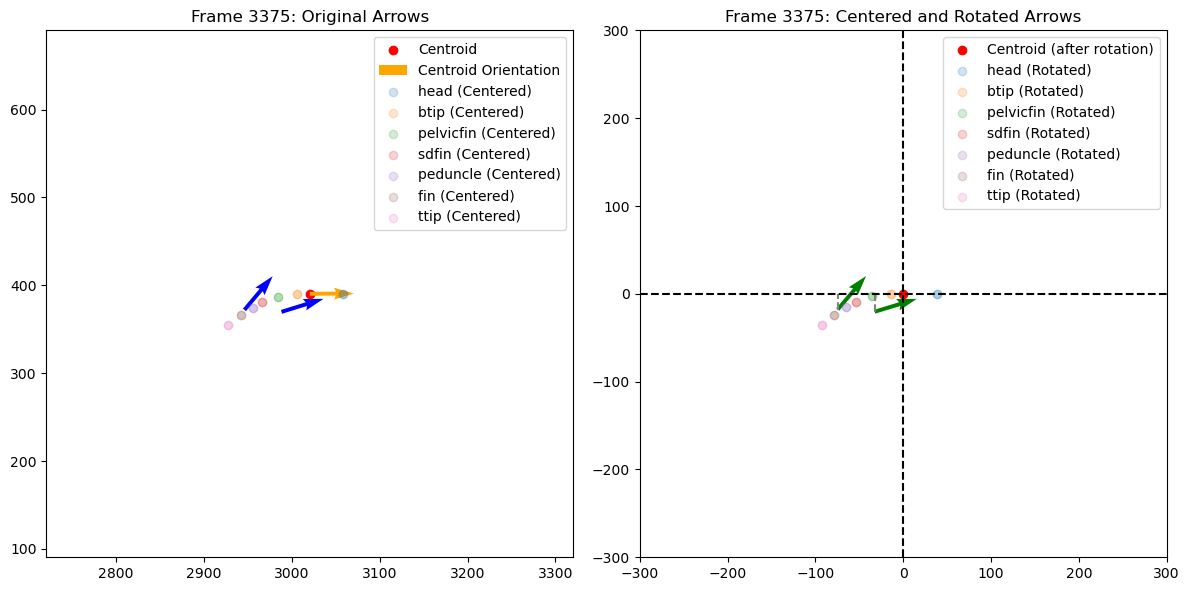

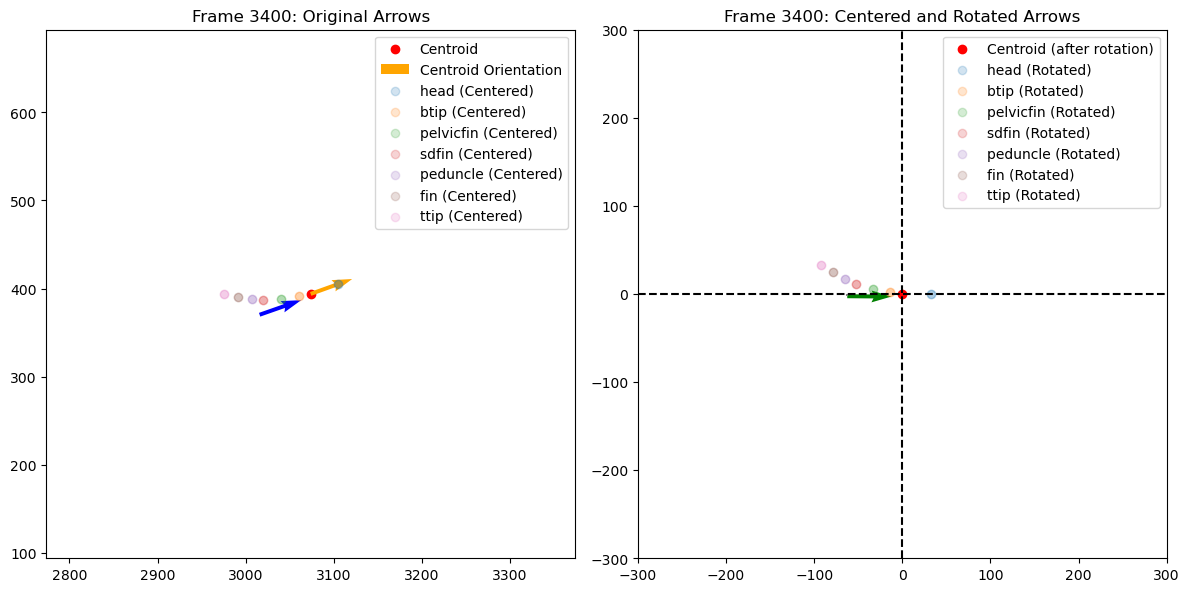

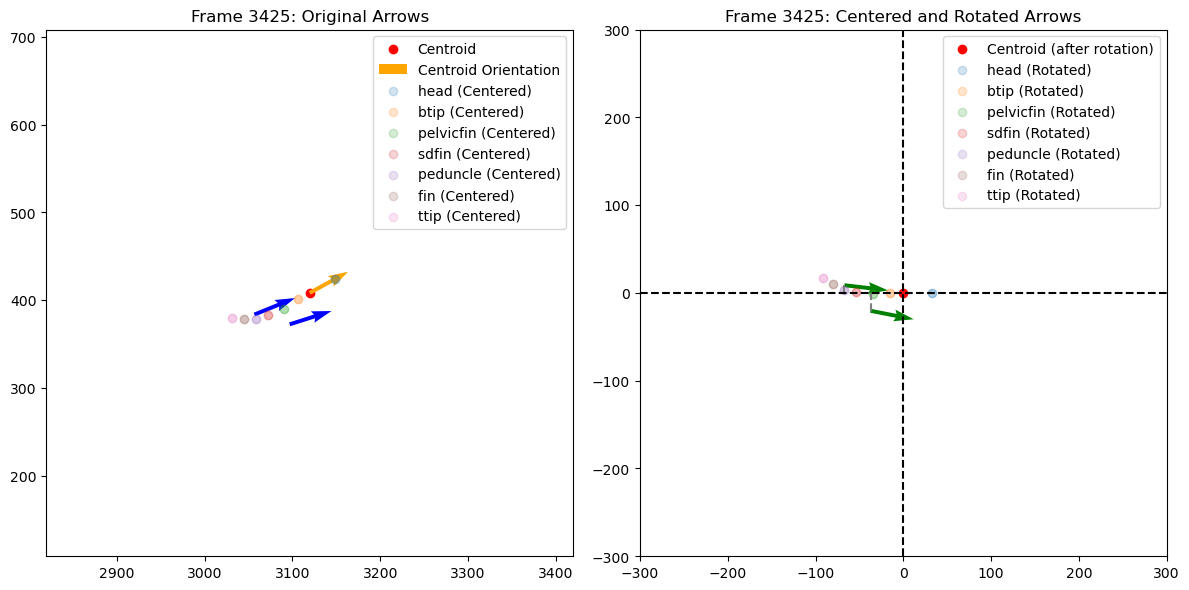

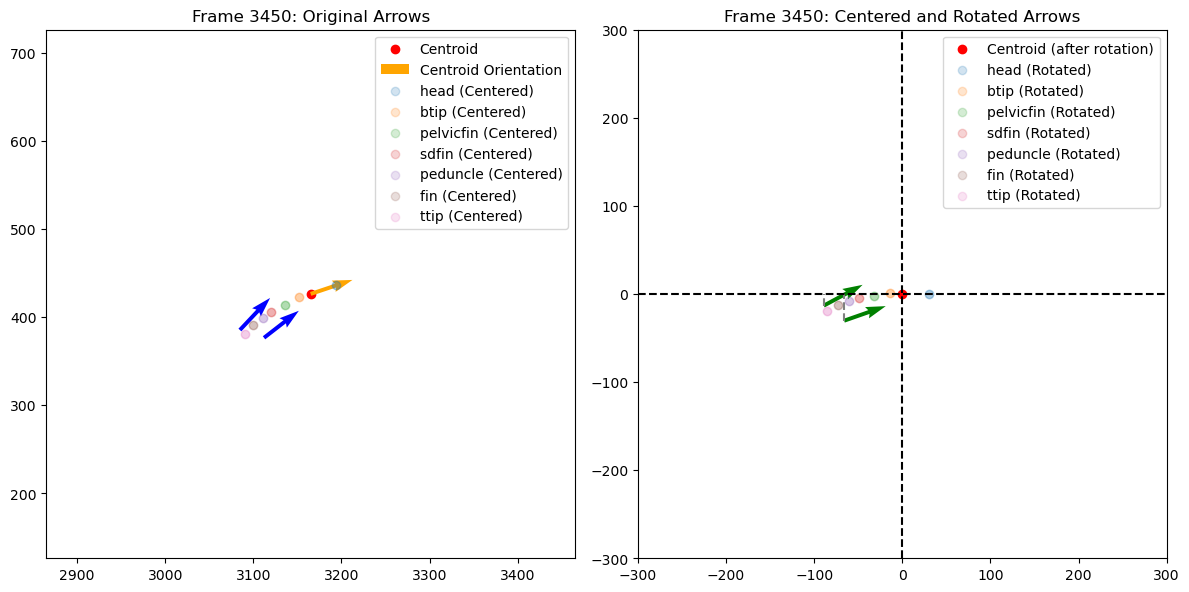

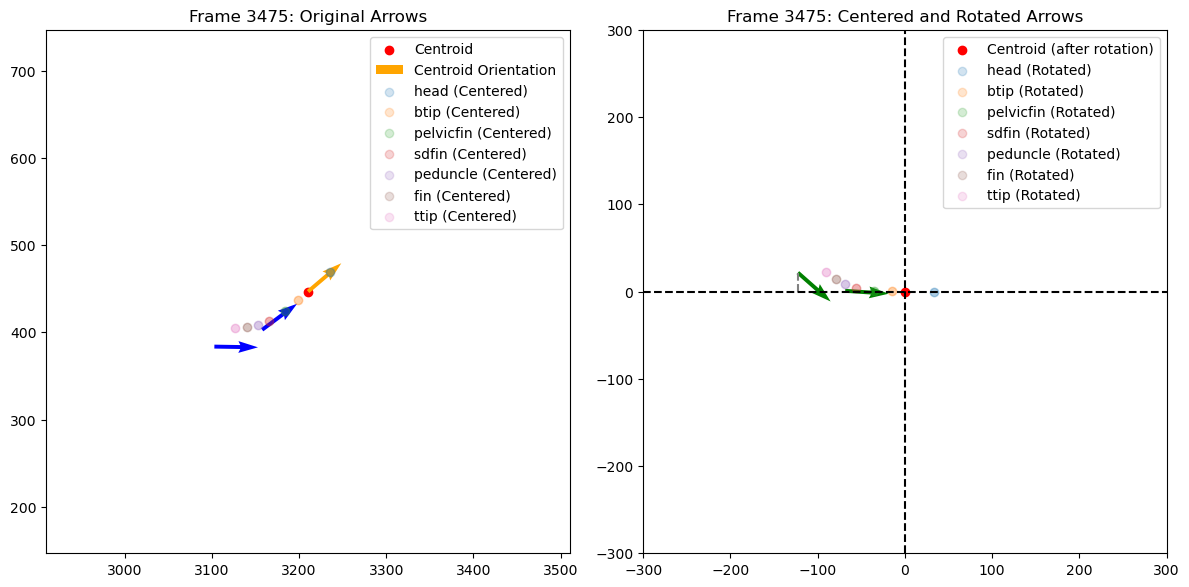

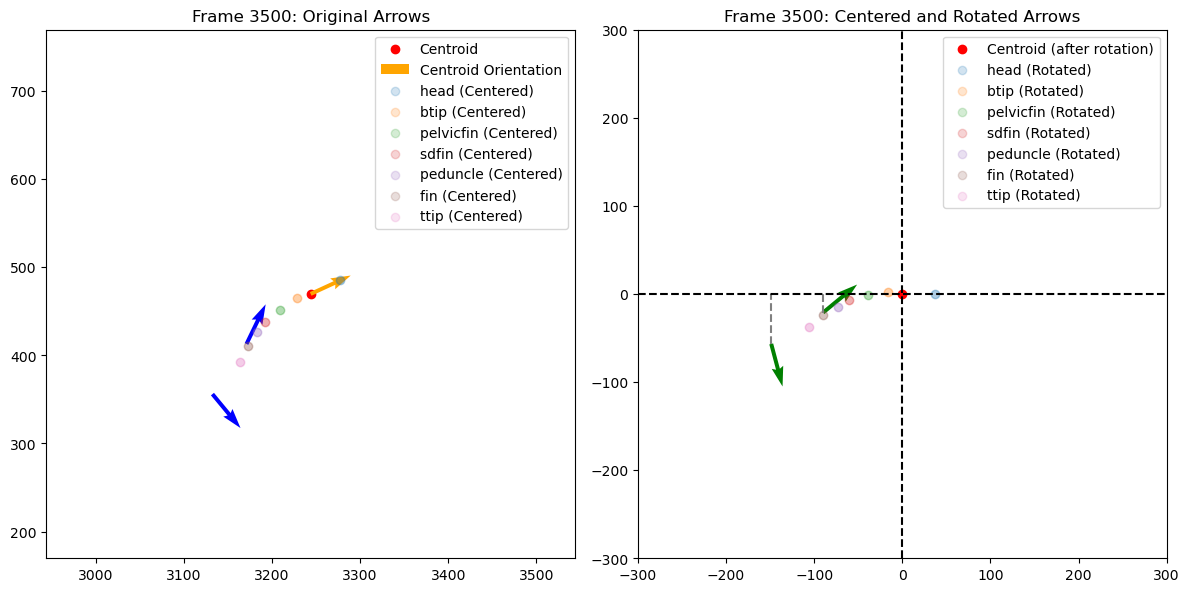

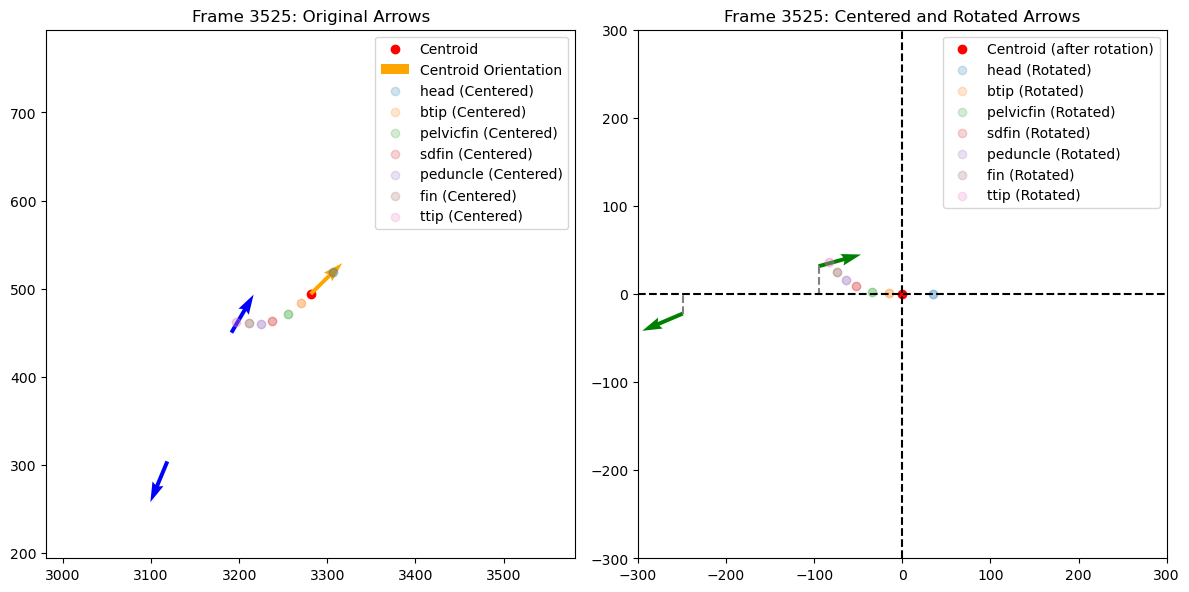

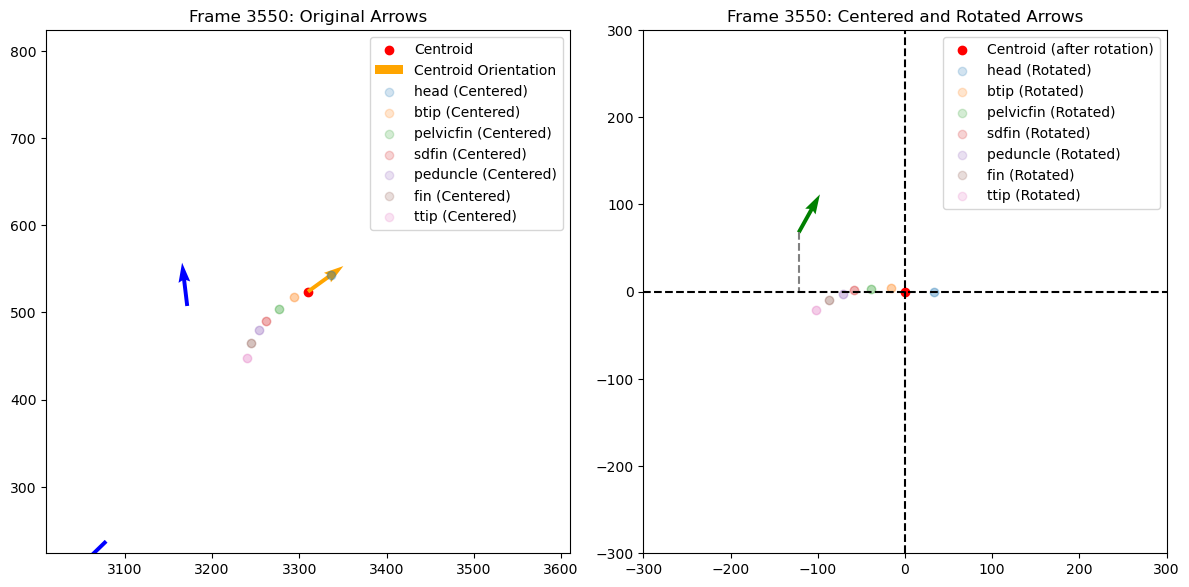

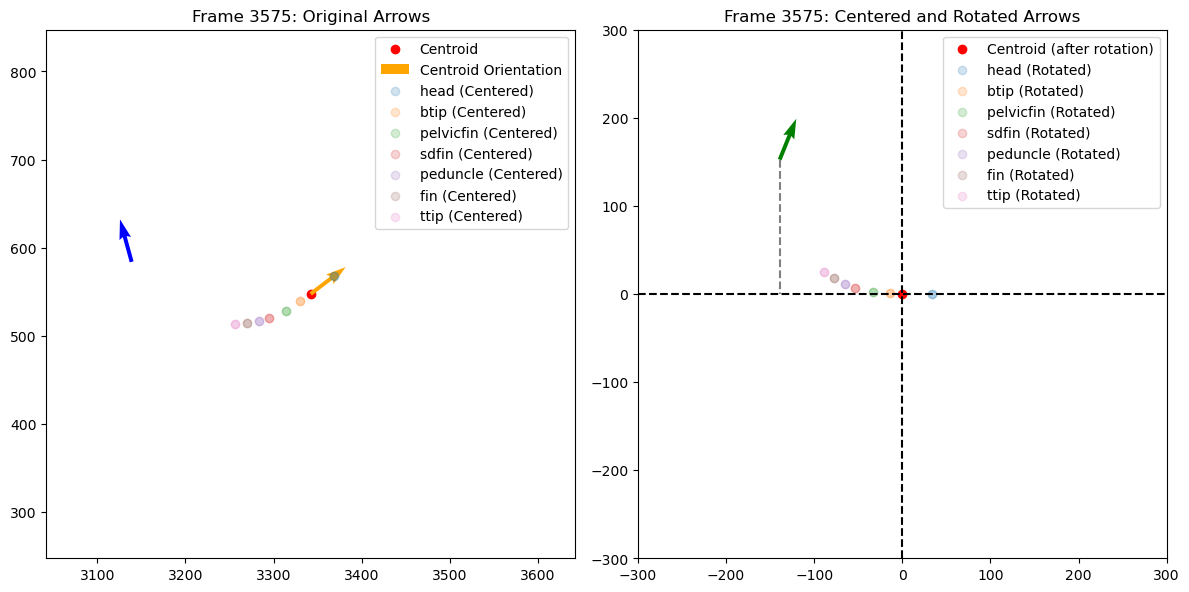

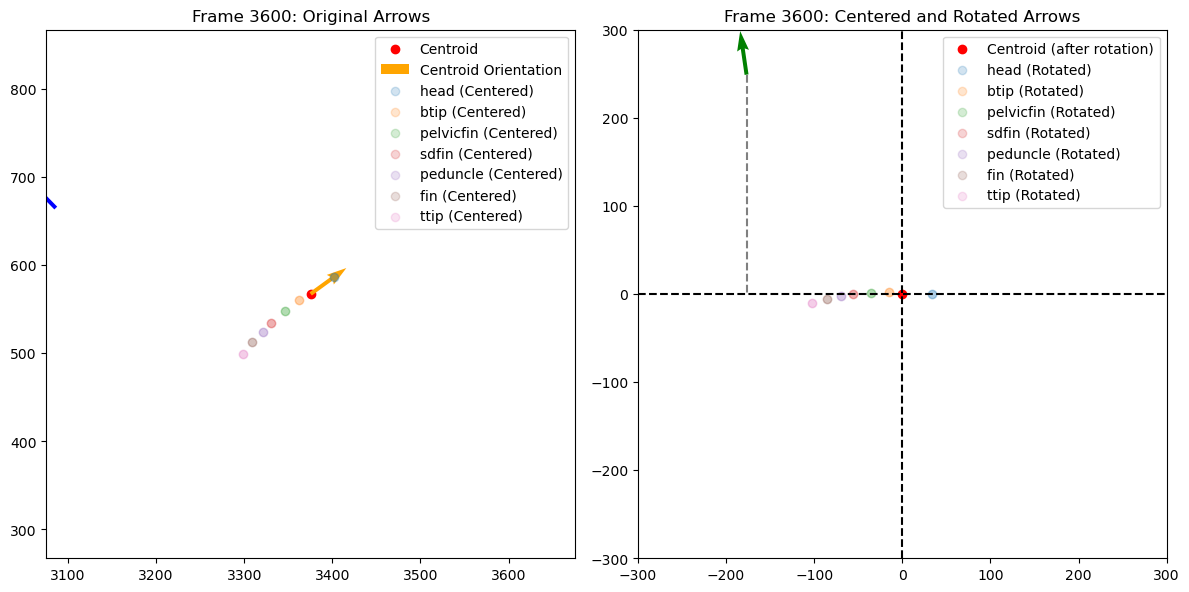

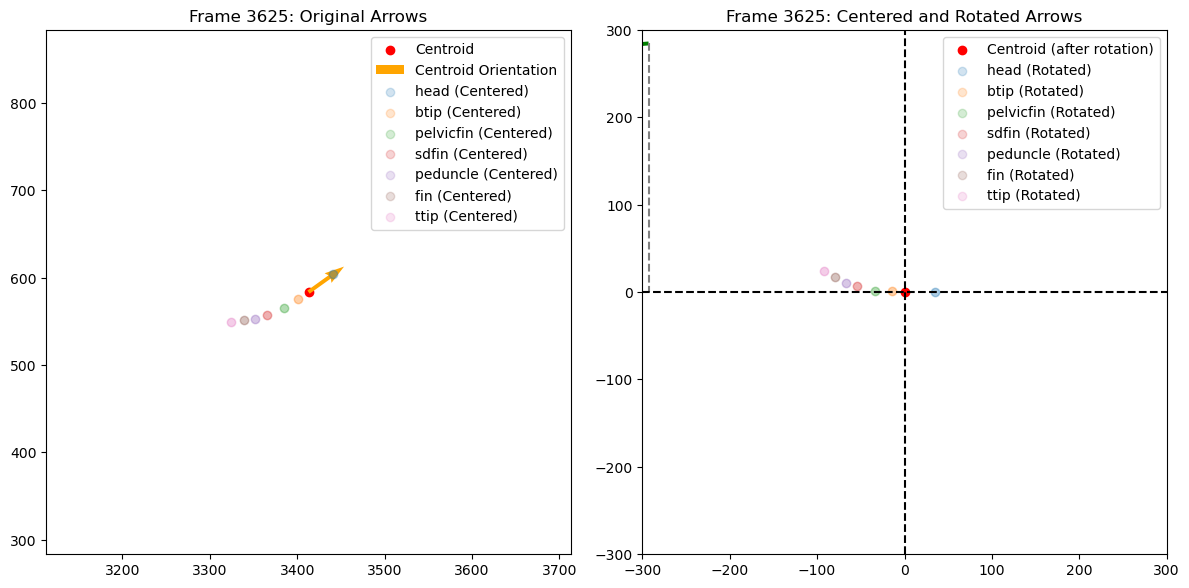

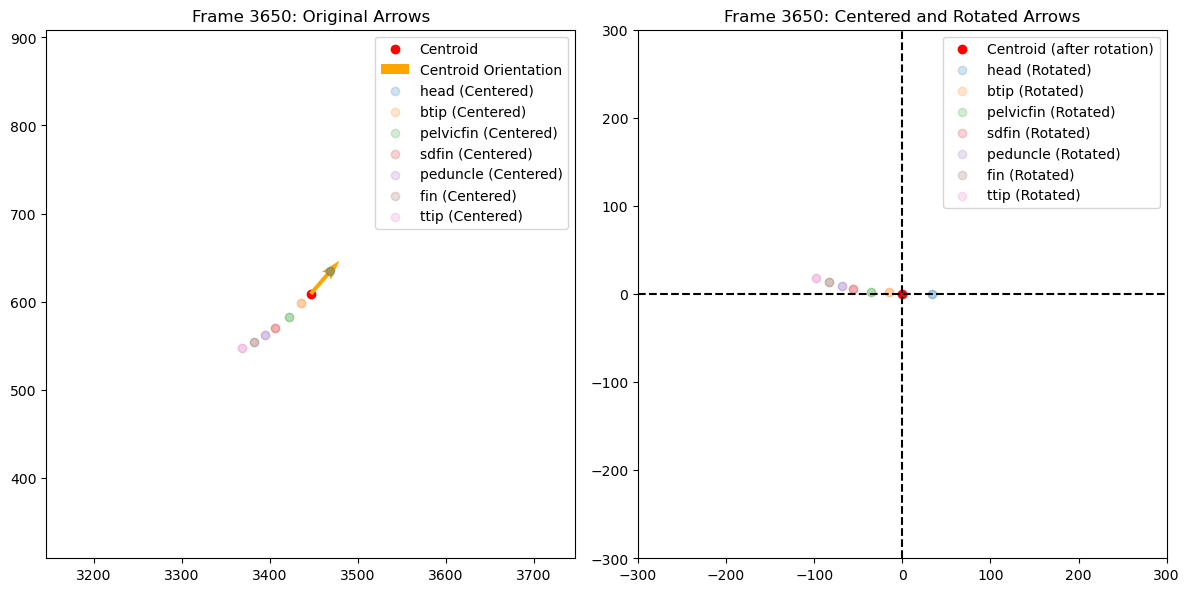

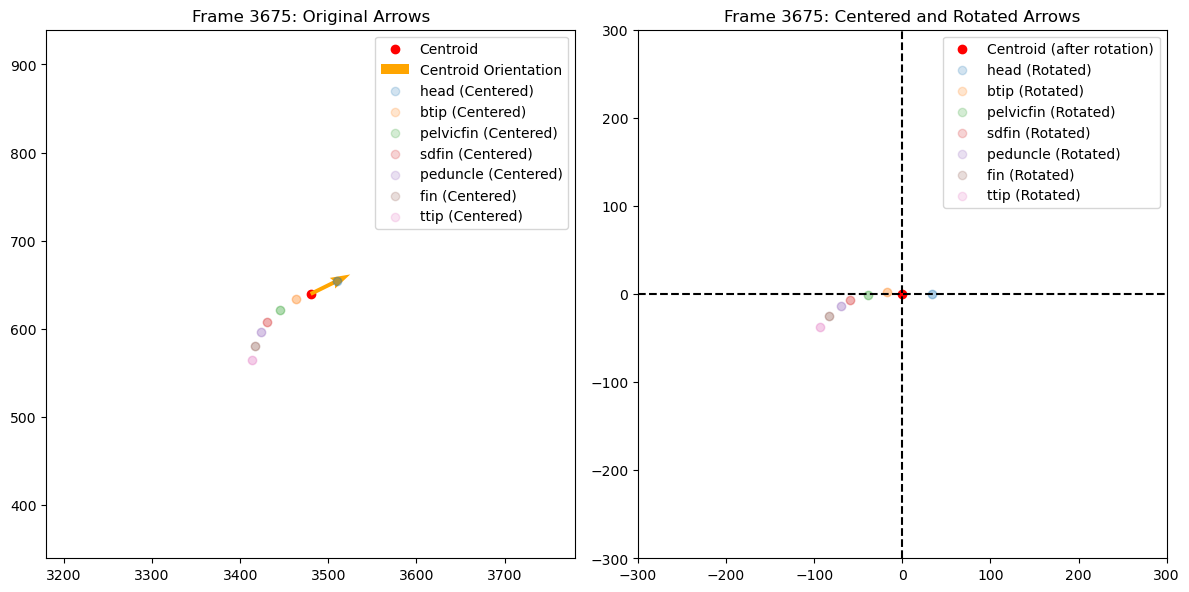

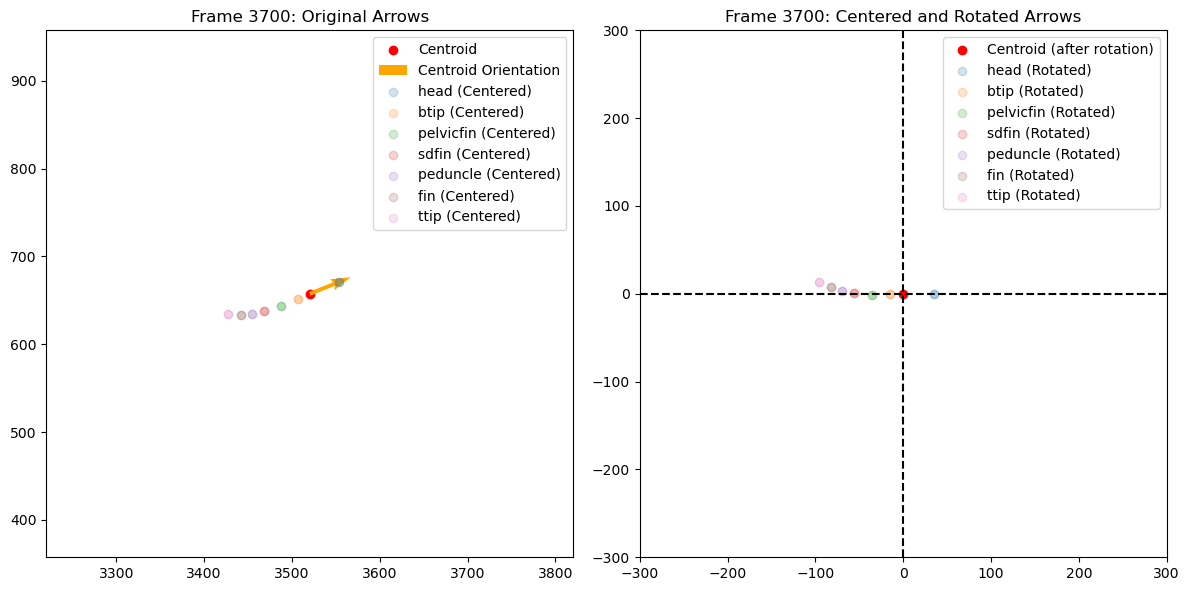

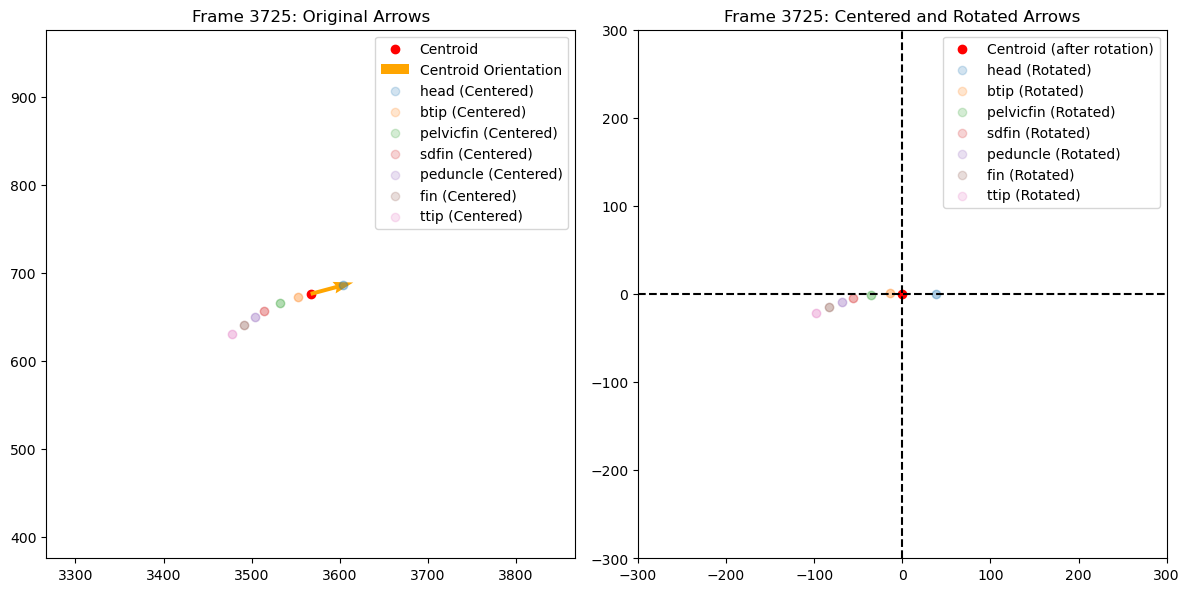

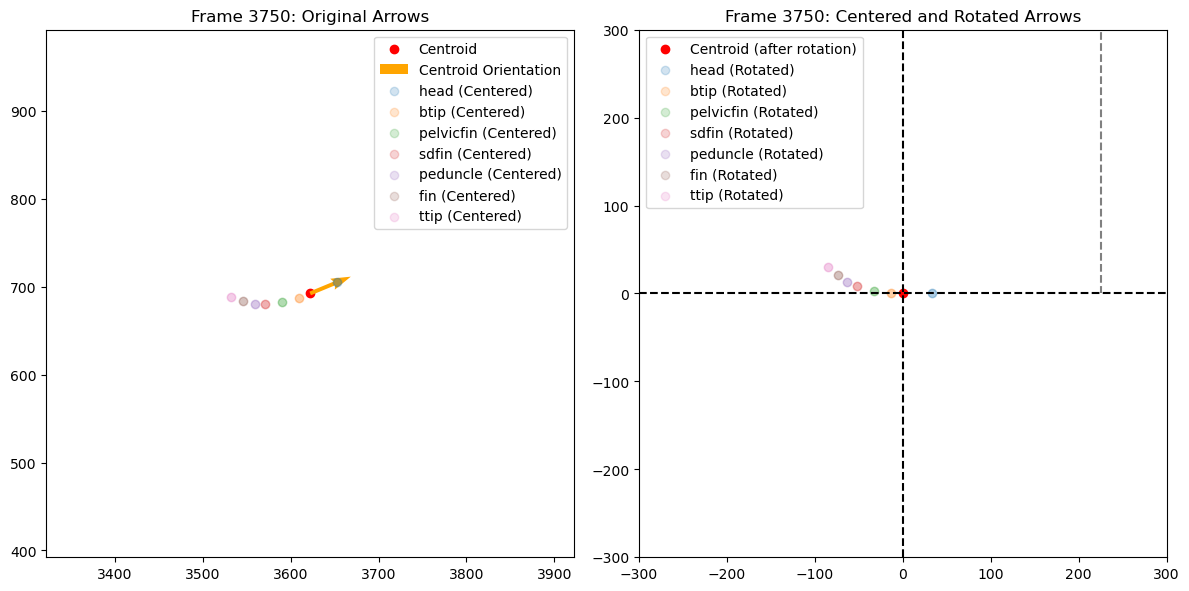

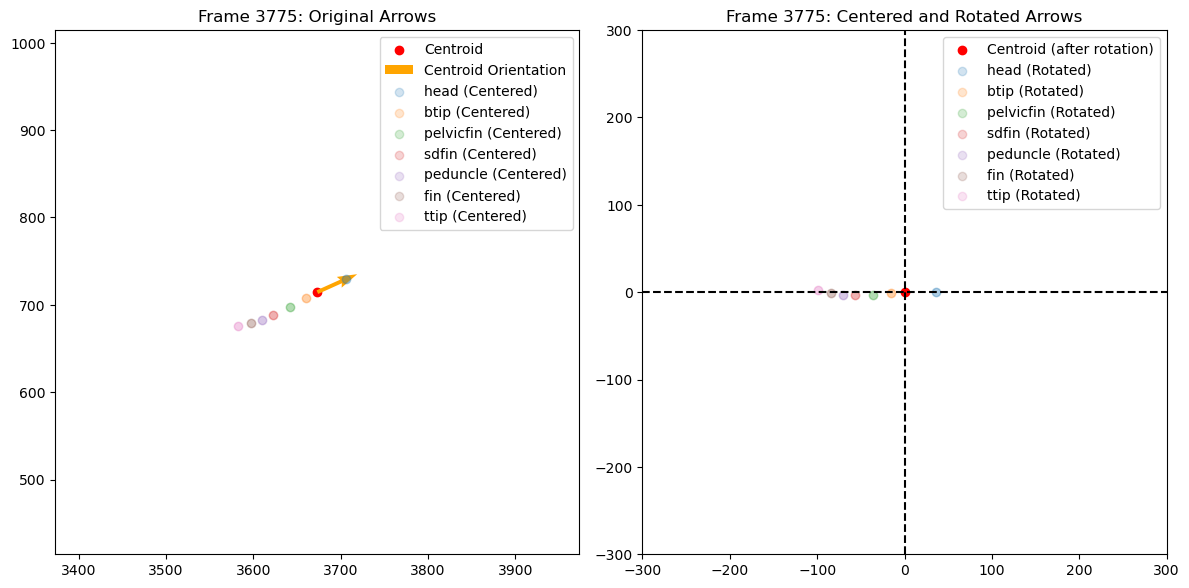

ValueError: Axis limits cannot be NaN or Inf

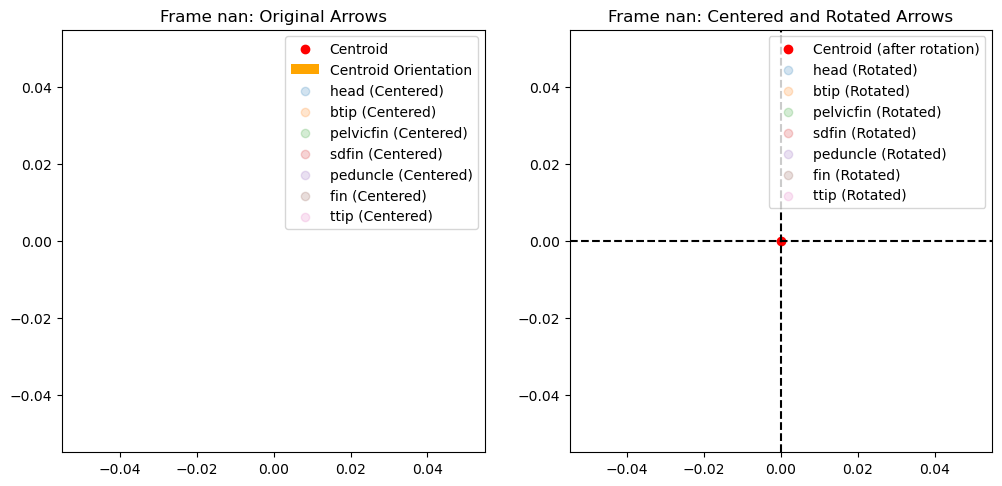

In [116]:
# Get the number of unique IDs (arrows)
num_arrows = fil_subset['carangid_id'].nunique()

# List of body part columns
body_parts = ['head', 'btip', 'pelvicfin', 'sdfin', 'peduncle', 'fin', 'ttip']

# Set range size for dynamic axis limits
range_size = 300  # Adjust based on your data

# Loop through each unique frame in 'fil_subset'
for frame in fil_subset['frame'].unique():
    # Extract the data for the current frame
    frame_data = fil_subset[fil_subset['frame'] == frame]
    
    # Extract positions and directions
    positions = frame_data[['chead_x', 'chead_y']].to_numpy()
    directions = frame_data[['heading_c']].to_numpy()

    # Calculate the centroid for the current frame
    centroid = frame_data[['midpoint_x', 'midpoint_y']].mean(axis=0).values

    # Get the centroid direction (heading) for the current frame
    centroid_direction = frame_data['heading'].mean()

    # Center the positions by subtracting the centroid
    positions_centered = positions - centroid

    # Calculate the rotation matrix based on the centroid direction
    rotation_matrix = np.array([
        [np.cos(-centroid_direction), -np.sin(-centroid_direction)],
        [np.sin(-centroid_direction), np.cos(-centroid_direction)]
    ])

    # Rotate the positions and directions
    positions_rotated = np.dot(positions_centered, rotation_matrix.T)
    directions_rotated = directions - centroid_direction

    # Create the figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    ### Left plot: Original Arrows & Centered Body Points ###
    axes[0].quiver(positions[:, 0], positions[:, 1],
                   np.cos(directions), np.sin(directions),
                   angles='xy', scale_units='xy', scale=0.02, color='blue')
    axes[0].scatter(centroid[0], centroid[1], color='red', label="Centroid")
    axes[0].quiver(centroid[0], centroid[1],
                   np.cos(centroid_direction), np.sin(centroid_direction),
                   angles='xy', scale_units='xy', scale=0.02, color='orange', label="Centroid Orientation")
    axes[0].set_title(f"Frame {frame}: Original Arrows")
    axes[0].set_aspect('equal')

    # Plot centered body part points (original, non-rotated)
    for part in body_parts:
        original_x = frame_data[f'{part}x'].to_numpy()
        original_y = frame_data[f'{part}y'].to_numpy()

        # Scatter plot with slight transparency
        axes[0].scatter(original_x, original_y, label=f"{part} (Centered)", alpha=0.2)

    axes[0].legend()

    ### Right plot: Centered & Rotated Arrows ###
    axes[1].quiver(positions_rotated[:, 0], positions_rotated[:, 1],
                   np.cos(directions_rotated), np.sin(directions_rotated),
                   angles='xy', scale_units='xy', scale=0.02, color='green')
    axes[1].scatter(0, 0, color='red', label="Centroid (after rotation)")

    # Plot rotated body part points
    for part in body_parts:
        rotated_x = frame_data[f'rotated_{part}x'].to_numpy()
        rotated_y = frame_data[f'rotated_{part}y'].to_numpy()
        axes[1].scatter(rotated_x, rotated_y, label=f"{part} (Rotated)", alpha=0.2)

    # Dashed projections to y=0
    for i in range(len(positions_rotated)):
        axes[1].plot([positions_rotated[i, 0], positions_rotated[i, 0]],
                     [positions_rotated[i, 1], 0], linestyle='--', color='gray')

    axes[1].set_title(f"Frame {frame}: Centered and Rotated Arrows")
    axes[1].set_aspect('equal')
    axes[1].legend()
    axes[1].axhline(y=0, color='k',linestyle='--')
    axes[1].axvline(x=0, color='k',linestyle='--')

    # Set dynamic axis limits
    axes[0].set_xlim(centroid[0] - range_size, centroid[0] + range_size)
    axes[0].set_ylim(centroid[1] - range_size, centroid[1] + range_size)
    axes[1].set_xlim(-range_size, range_size)
    axes[1].set_ylim(-range_size, range_size)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


#### Polar plot

In [41]:
# Filter the dataset to only include rows where carangids == 1
filtered_subset = subset[subset['carangids'] == 1]

# Initialize empty lists to store the results
rotated_positions_list = []
rotated_directions_list = []
id_list = []  # To keep track of which ID each row belongs to

# Group by 'frame' and 'ID' to process each unique ID separately within each frame
for (frame, ID), group in filtered_subset.groupby(['frame', 'ID']):
    
    # Get the positions (chead_x, chead_y) for the current ID and frame
    positions = group[['chead_x', 'chead_y']].to_numpy()
    
    # Get the directions (heading_c) for the current ID and frame
    directions = group[['heading_c']].to_numpy()

    # Calculate the centroid for the current frame based on all carangids==1
    centroid = filtered_subset.groupby('frame')[['midpoint_x', 'midpoint_y']].mean().loc[frame].values
    
    # Get the centroid direction (heading) for the current frame
    centroid_direction = filtered_subset.groupby('frame')['heading'].mean().loc[frame]
    
    # Center the positions by subtracting the centroid for the current frame
    positions_centered = positions - centroid
    
    # Calculate the rotation matrix based on the centroid direction
    rotation_matrix = np.array([
        [np.cos(-centroid_direction), -np.sin(-centroid_direction)],
        [np.sin(-centroid_direction), np.cos(-centroid_direction)]
    ])
    
    # Rotate the positions for the current ID and frame
    positions_rotated = np.dot(positions_centered, rotation_matrix.T)
    
    # Rotate the directions (same as positions) by subtracting the centroid direction
    directions_rotated = directions - centroid_direction
    
    # Append the results to the lists
    rotated_positions_list.append(positions_rotated)
    rotated_directions_list.append(directions_rotated)
    id_list.extend([ID] * len(positions_rotated))  # Store corresponding ID values

# Convert lists to numpy arrays
rotated_positions = np.vstack(rotated_positions_list)
rotated_directions = np.concatenate(rotated_directions_list)
id_array = np.array(id_list)  # Keep IDs aligned with transformed data

# Create a DataFrame with the transformed data
rotated_df = pd.DataFrame({
    'ID': id_array,
    'rotated_x': rotated_positions[:, 0],
    'rotated_y': rotated_positions[:, 1],
    'rotated_heading': rotated_directions.flatten()
})

# If needed, reset the index
rotated_df.reset_index(drop=True, inplace=True)

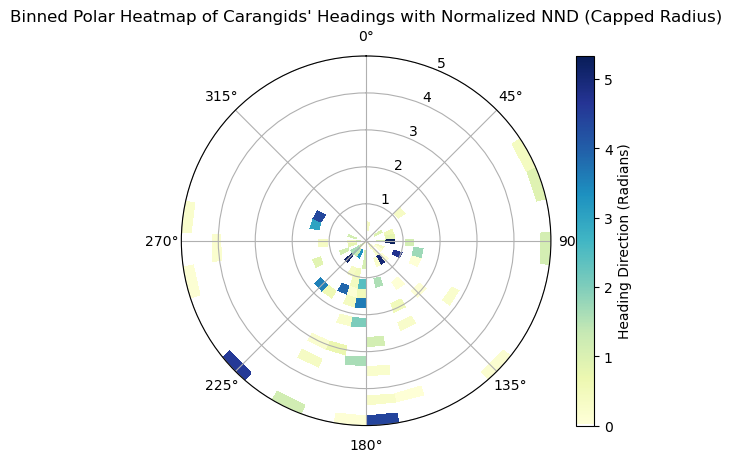

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Cap the radius to a maximum of 2
rotated_df['radius'] = np.clip(subset['normalized_nnd_c'], 0, 5)

# Convert (x, y) to Polar Coordinates for angle
rotated_df['angle'] = np.arctan2(rotated_df['rotated_y'], rotated_df['rotated_x'])

# Keep the heading in radians (no normalization)
rotated_df['heading'] = rotated_df['rotated_heading']  # No normalization here

# Define bins for angle and radius
num_angle_bins = 36  # 10-degree bins
num_radius_bins = 20  # Adjust based on desired number of radial bins
angle_bins = np.linspace(-np.pi, np.pi, num_angle_bins)  # Angle bins in radians
radius_bins = np.linspace(0, 5, num_radius_bins)  # Cap the radius to 2

# Compute a 2D histogram using heading as values
heatmap, _, _ = np.histogram2d(rotated_df['angle'], rotated_df['radius'], 
                               bins=[angle_bins, radius_bins], weights=rotated_df['heading'])

# Create a meshgrid for plotting
theta, r = np.meshgrid(angle_bins, radius_bins)

# Create a custom colormap with white as the minimum value and 'inferno' for the rest
cmap = ListedColormap(plt.cm.YlGnBu(np.linspace(0, 1, 256)))
cmap.colors[0] = [1, 1, 1, 1]  # Set the first color (lowest value) to white

# Plot the polar heatmap
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Set the vmin to 0 so that areas with no data appear white
c = ax.pcolormesh(theta, r, heatmap.T, cmap=cmap, shading='auto', vmin=0)

# Add colorbar to show heading direction
plt.colorbar(c, label="Heading Direction (Radians)")

# Set aesthetics
ax.set_theta_zero_location('N')  # Set 0 radians (North) at the top
ax.set_theta_direction(-1)  # Make angles increase clockwise
plt.title("Binned Polar Heatmap of Carangids' Headings with Normalized NND (Capped Radius)")

# Adjust plot limits for better clarity (optional)
ax.set_ylim(0, 5)  # Set radius limit to 2 to match the capped radius

plt.show()



In [35]:
# Step 1: Calculate relative x and y distances between the focal fish and its nearest neighbor (carangid)
subset["delta_x"] = subset["chead_x"] - subset["midpoint_x"]
subset["delta_y"] = subset["chead_y"] - subset["midpoint_y"]

# Step 1: Use the 'nearest_neighbor' column to look up the appropriate heading for the focal fish's nearest neighbor.
# We will use .loc to get the heading of the nearest neighbor dynamically.
subset["focal_heading"] = subset.apply(
    lambda row: row["heading"] if row["nearest_neighbor_c"] == row["ID"]
    else subset.loc[subset["ID"] == row["nearest_neighbor_c"], "heading"].values[0],
    axis=1)

# Step 3: Compute the absolute angle between focal fish and nearest neighbor (carangid)
subset["theta_absolute"] = np.arctan2(subset["delta_y"], subset["delta_x"])

# Step 4: Calculate the relative heading (from focal fish’s perspective)
subset["theta_relative"] = subset["theta_absolute"] - subset["focal_heading"]

# Step 4: Calculate the relative heading (from focal fish’s perspective)
subset["theta_relative_c"] = subset["heading_c"] - subset["theta_absolute"]

# Step 5: Normalize the relative heading to the range (-π, π) for proper angular visualization
subset["theta_relative"] = np.arctan2(np.sin(subset["theta_relative"]), np.cos(subset["theta_relative"]))

# Step 5: Normalize the relative heading to the range (-π, π) for proper angular visualization
subset["theta_relative_c"] = np.arctan2(np.sin(subset["theta_relative_c"]), np.cos(subset["theta_relative_c"]))

In [43]:
# Create polar grid for the plot
theta_bins = np.linspace(-np.pi, np.pi, 360)  # 360 bins for angles (-π to π)
radius_bins = np.linspace(0, 3, 5)  # Adjust the number of bins for distance

# Calculate 2D histogram
hist, theta_edges, radius_edges = np.histogram2d(
    subset['theta_relative'], 
    subset['normalized_nnd_c'], 
    bins=[theta_bins, radius_bins], 
    weights=subset['theta_relative_c']  # Or another variable for coloring
)

# Create meshgrid for the polar plot
theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2  # Midpoint of the bins
radius_centers = (radius_edges[:-1] + radius_edges[1:]) / 2  # Midpoint of the bins

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Plot heatmap using pcolormesh (since pcolormesh works in polar coordinates)
c = ax.pcolormesh(theta_centers, radius_centers, hist.T, cmap='YlGnBu', shading='auto')

# Customize the plot
ax.set_title("Relative Heading Heatmap of Carangid (Neighbor) to Focal Fish")
ax.set_theta_zero_location("N")  # 0 degrees = "North" (up)
ax.set_theta_direction(-1)  # Clockwise angles

# Add color bar
fig.colorbar(c, ax=ax, label="Relative Heading or Intensity")

# Show plot
plt.show()

KeyError: 'theta_relative'

### Event/attack analysis

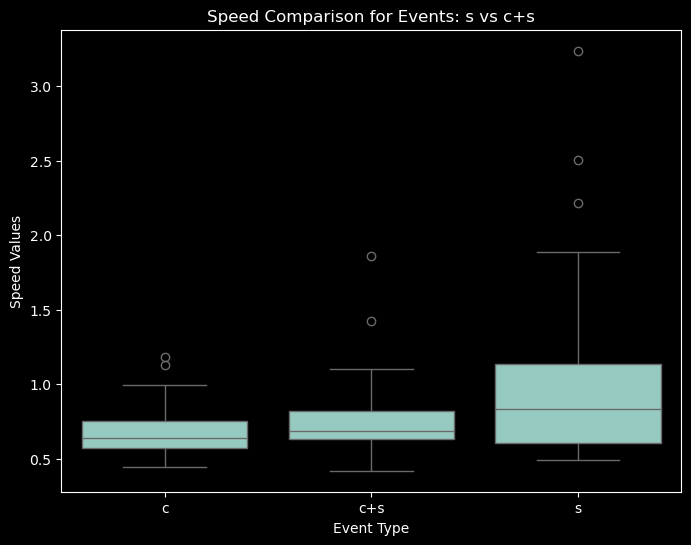

In [63]:

# Group by ID, segment, Trial and calculate the mean speed for each group
mean_speed = sharks_df.groupby(['ID', 'segment', 'Trial', 'events'])['standardized_speed'].mean().reset_index()

# Filter for events 's' and 'c+s'
mean_speed_filtered = mean_speed[mean_speed['events'].isin(['s', 'c+s','c'])]

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='events', y='standardized_speed', data=mean_speed_filtered)

# Add a title and labels
plt.title('Speed Comparison for Events: s vs c+s')
plt.xlabel('Event Type')
plt.ylabel('Speed Values')

# Show plot
plt.show()


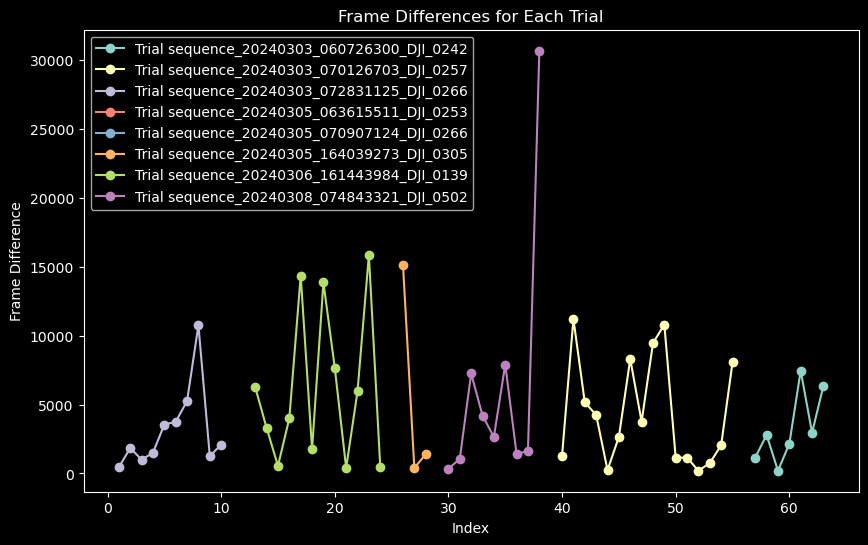

In [17]:
# Calculate frame differences within each trial
df_events['frame_diff'] = df_events.groupby('sequence_name')['start_frame'].diff()

# Plotting
plt.figure(figsize=(10, 6))

# Plot each trial separately
for trial, group in df_events.groupby('sequence_name'):
    plt.plot(group.index, group['frame_diff'], marker='o', label=f'Trial {trial}')

# Plot formatting
plt.title("Frame Differences for Each Trial")
plt.xlabel("Index")
plt.ylabel("Frame Difference")
plt.legend()
plt.show()

In [57]:
# Function to extract values around events
def extract_around_events(events_df, sharks_df, frame_window=200):
    result = []
    
    for _, event in events_df.iterrows():
        trial = event['sequence_name']
        event_timestamp = event['start_frame']
        
        # Filter sharks_df for the matching trial and frame window
        filtered = sharks_df[
            (sharks_df['Trial'] == trial) &
            (sharks_df['frame'] >= event_timestamp - frame_window) &
            (sharks_df['frame'] <= event_timestamp + frame_window)
        ]
        
        # Add the event and associated values to the result
        for _, row in filtered.iterrows():
            result.append({
                "Trial": trial,
                "start_frame": event_timestamp,
                "frame": row['frame'],
                "midpoint_x": row['midpoint_x'],
                "midpoint_y": row['midpoint_y'],
                "ID": row['ID']
            })
    
    return pd.DataFrame(result)

# Extract values
result_df = extract_around_events(df_events, sharks_df, frame_window=200)

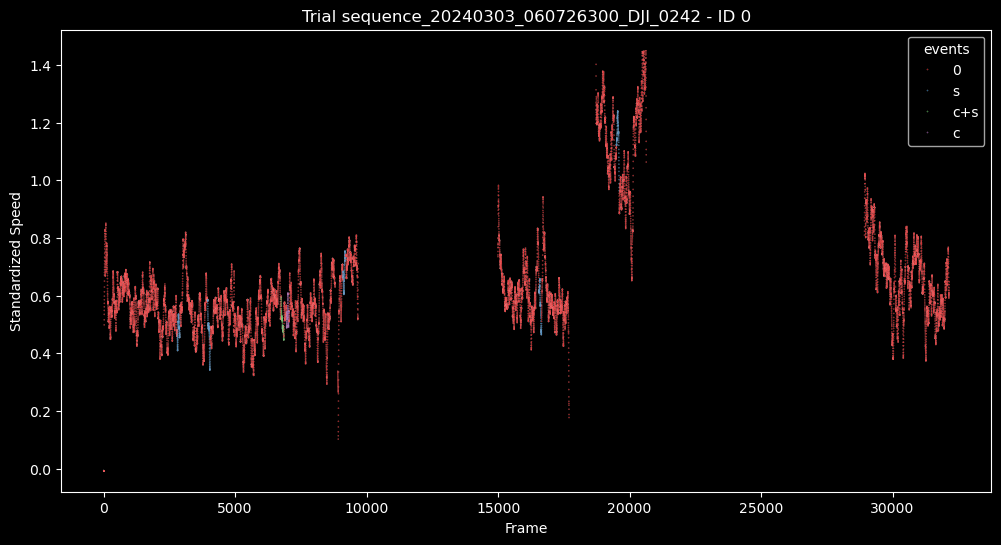

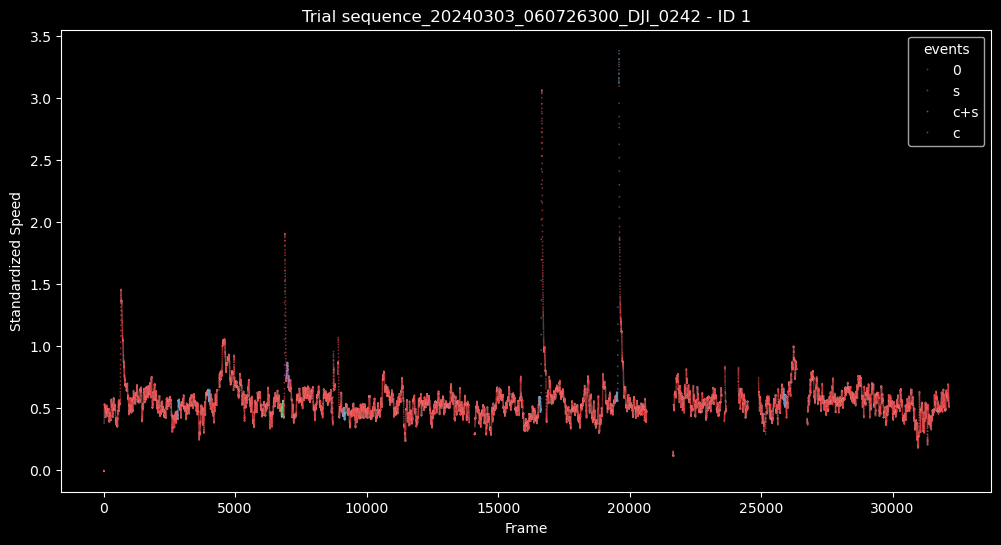

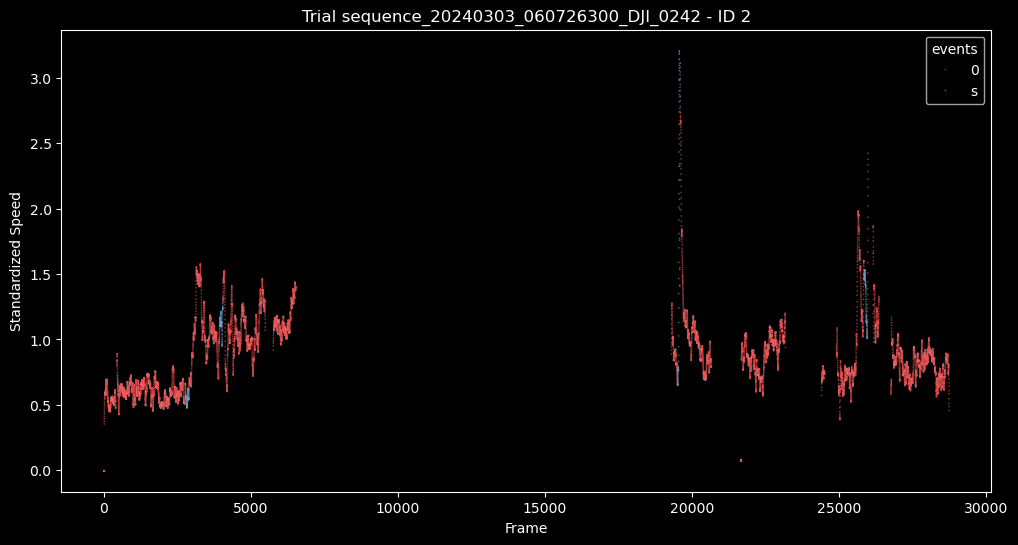

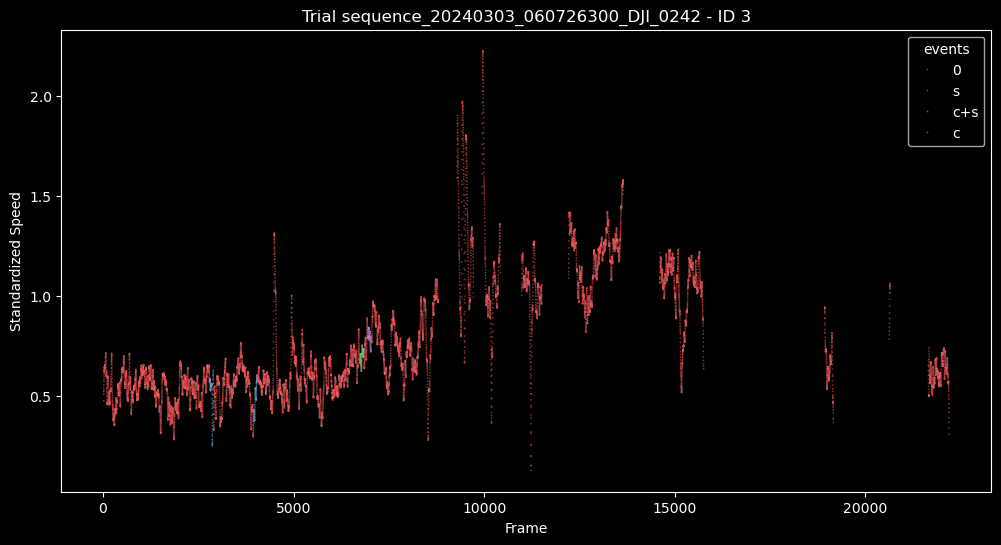

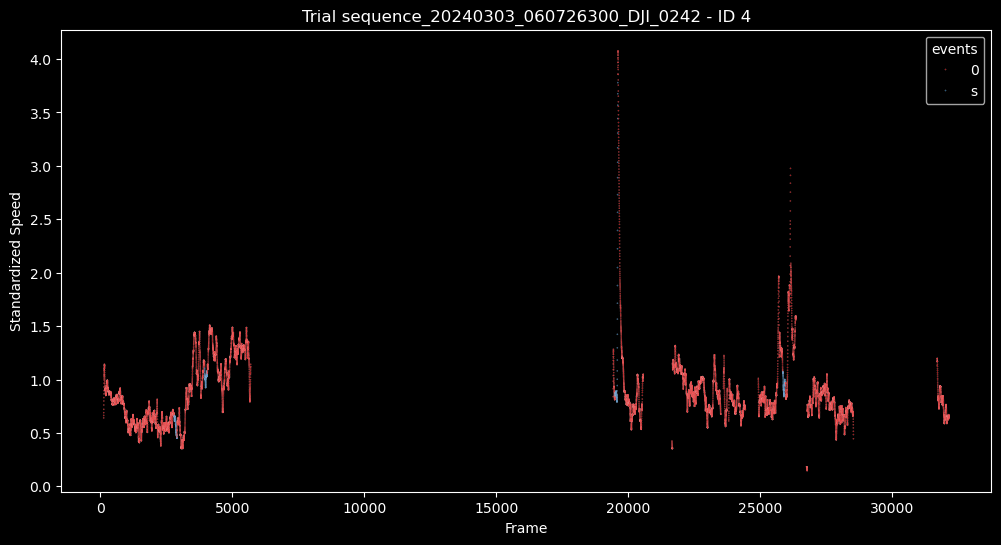

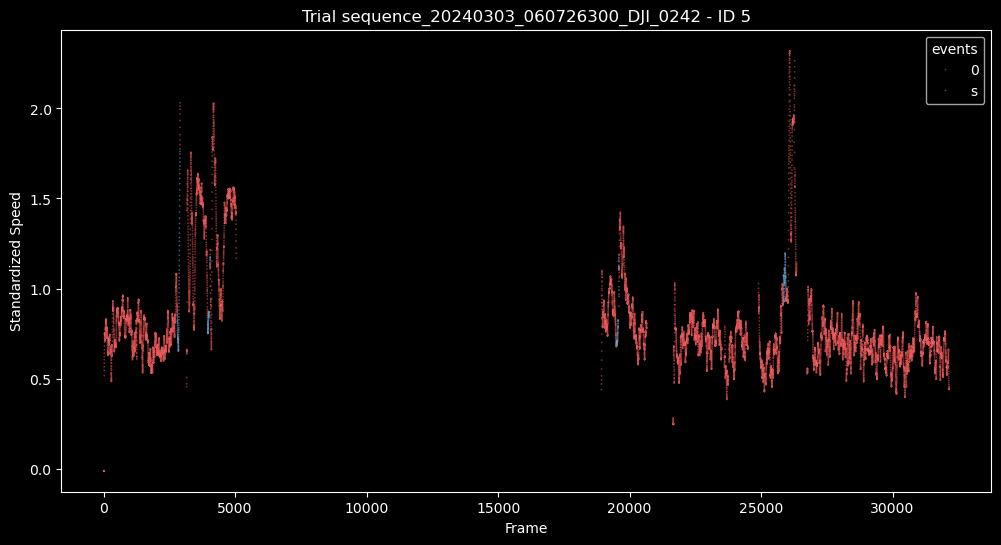

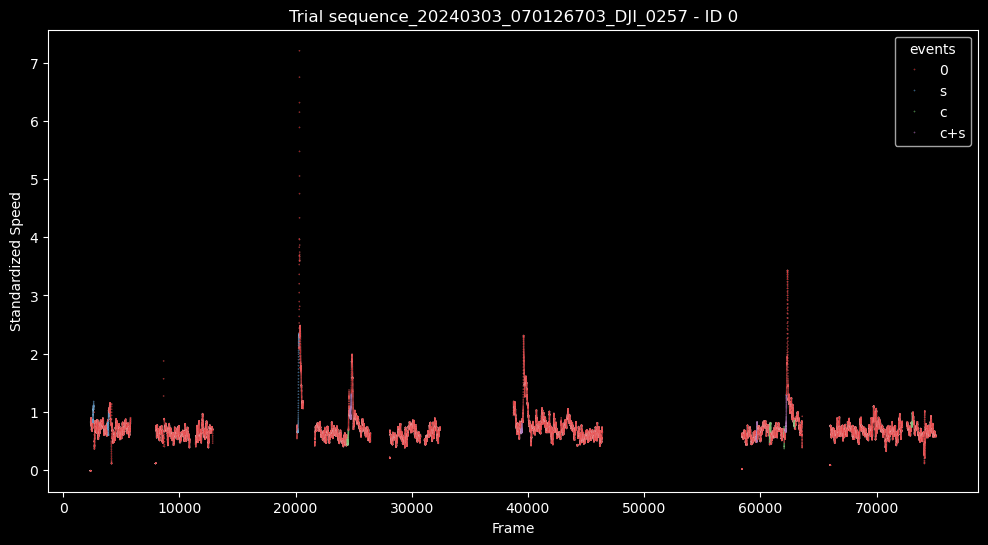

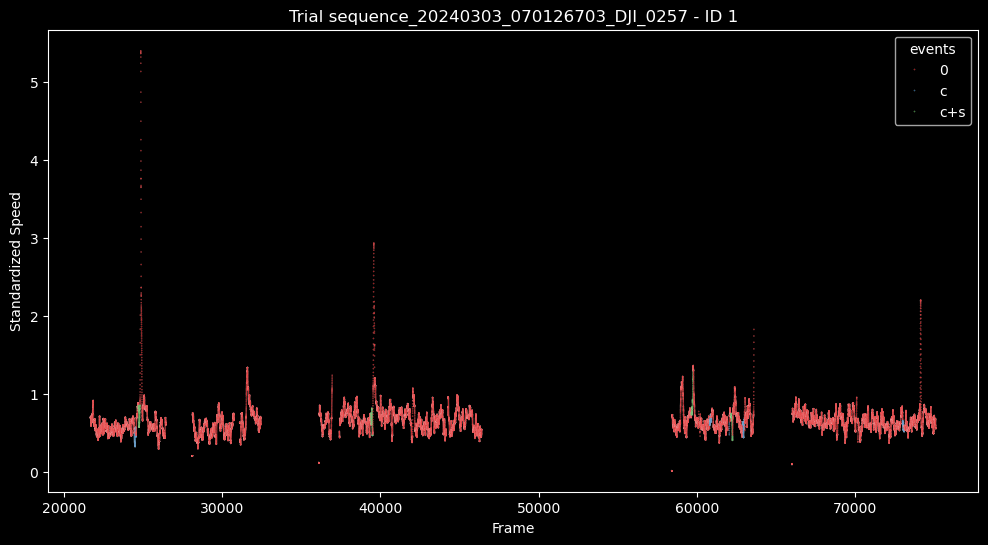

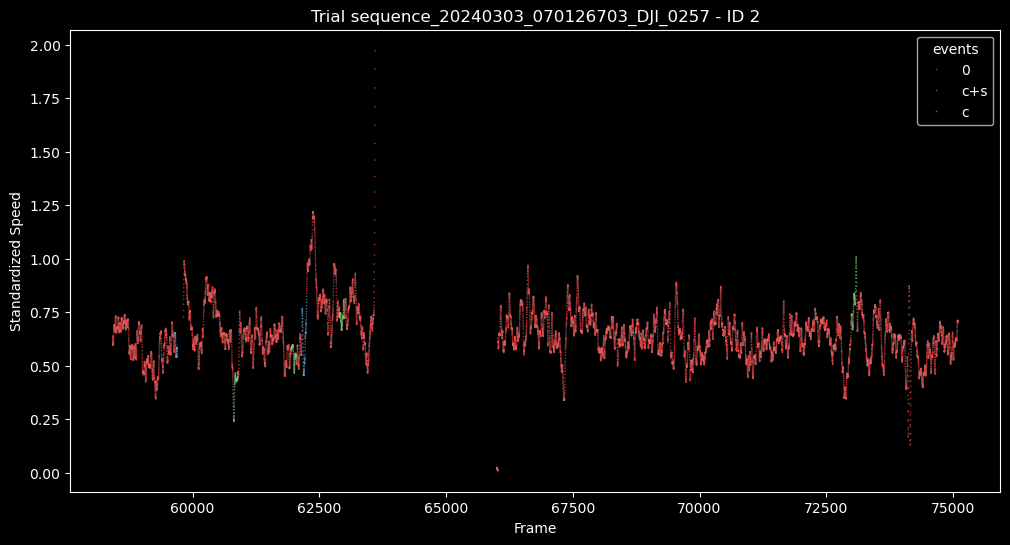

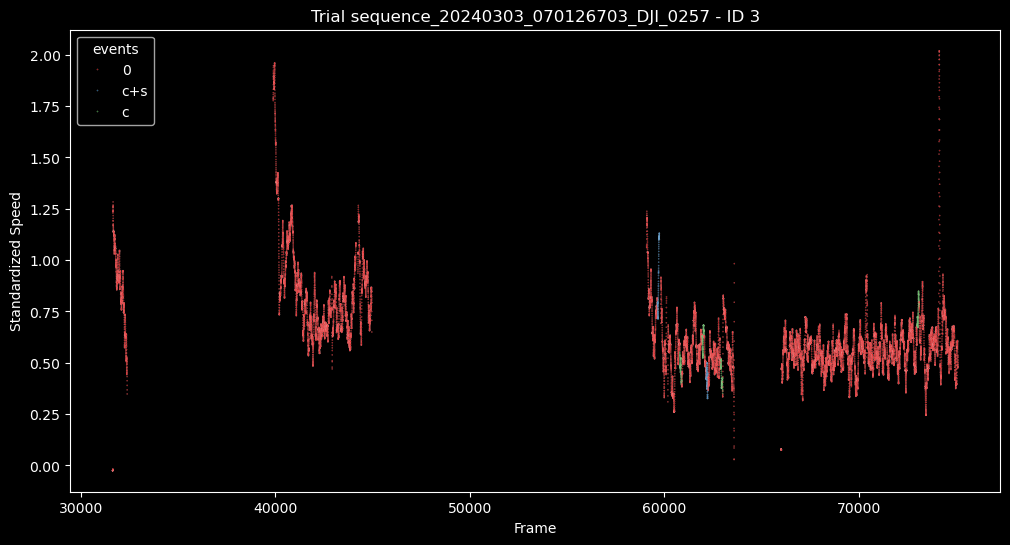

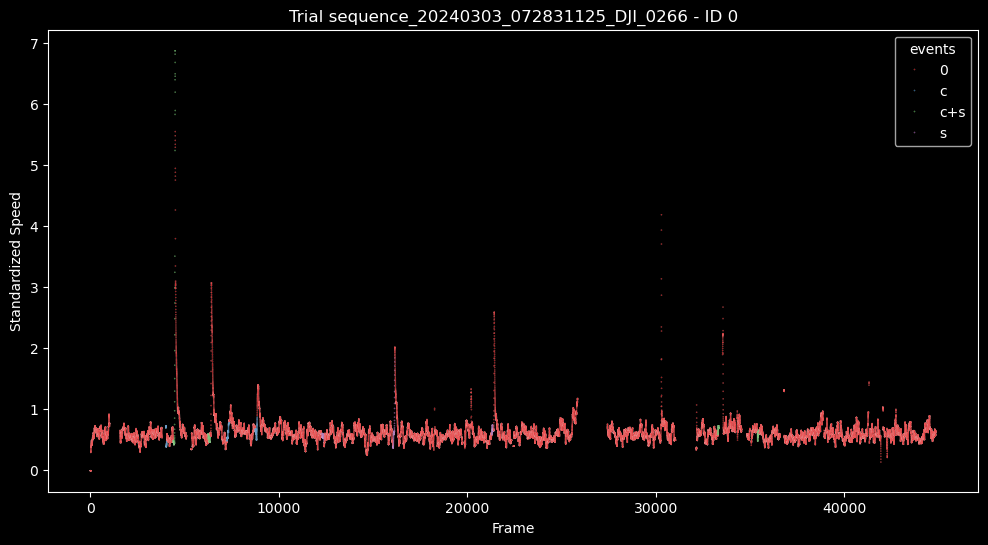

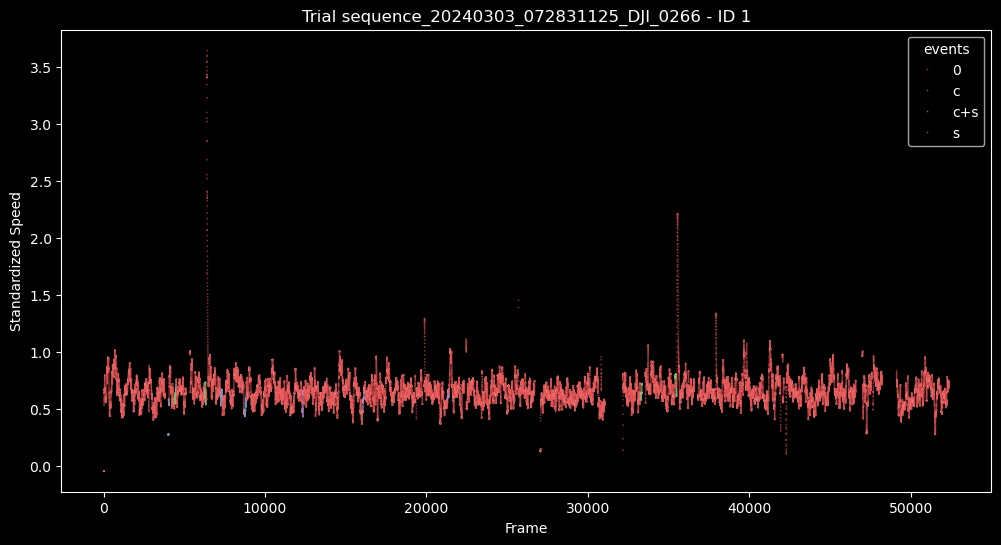

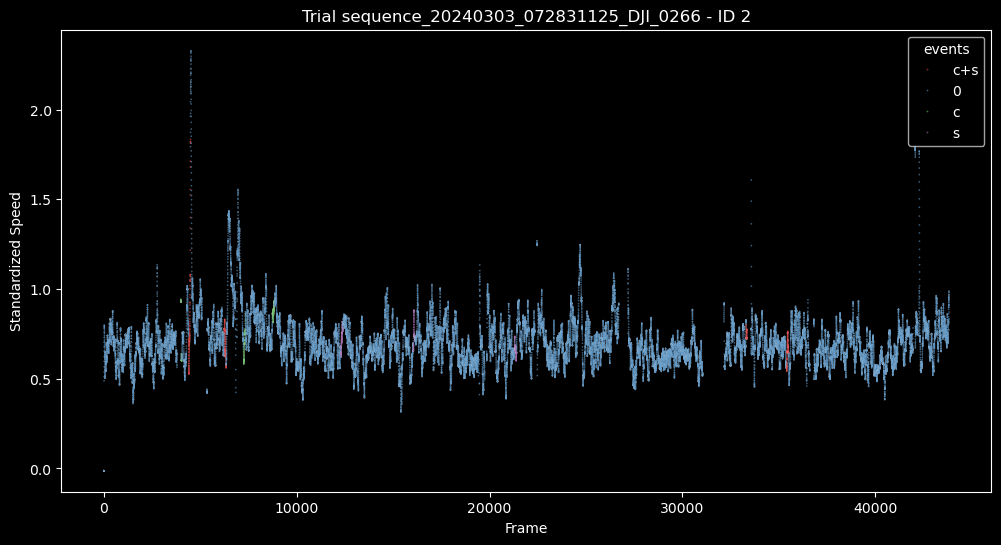

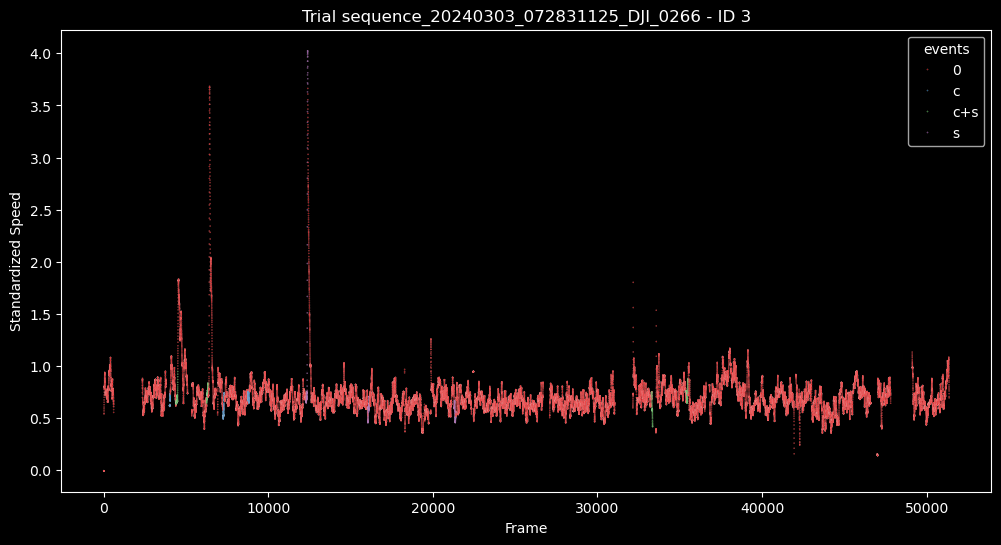

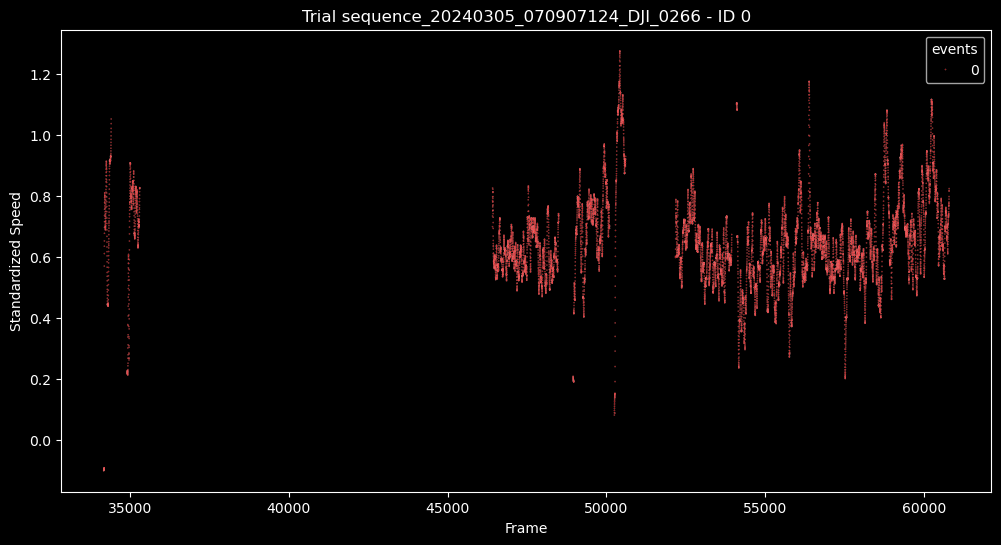

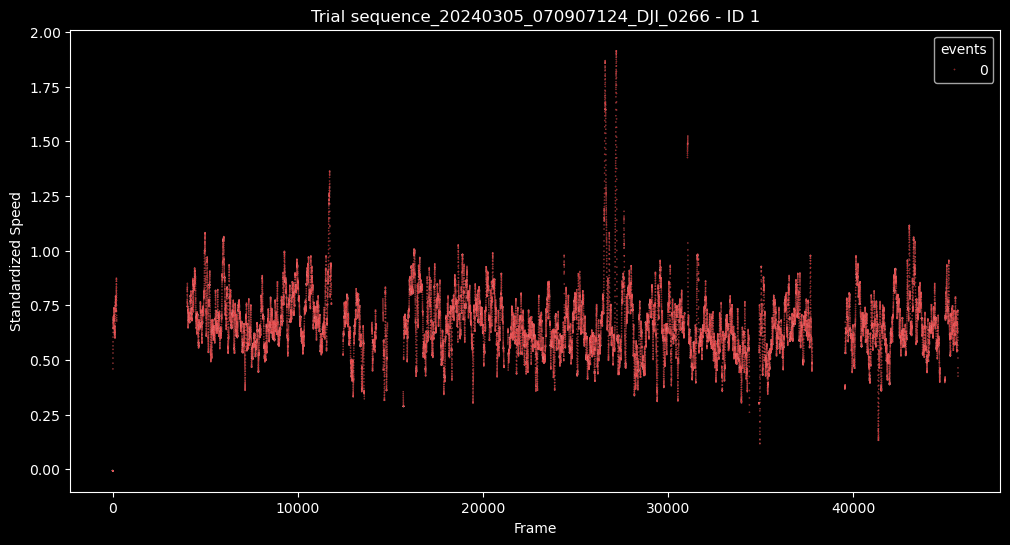

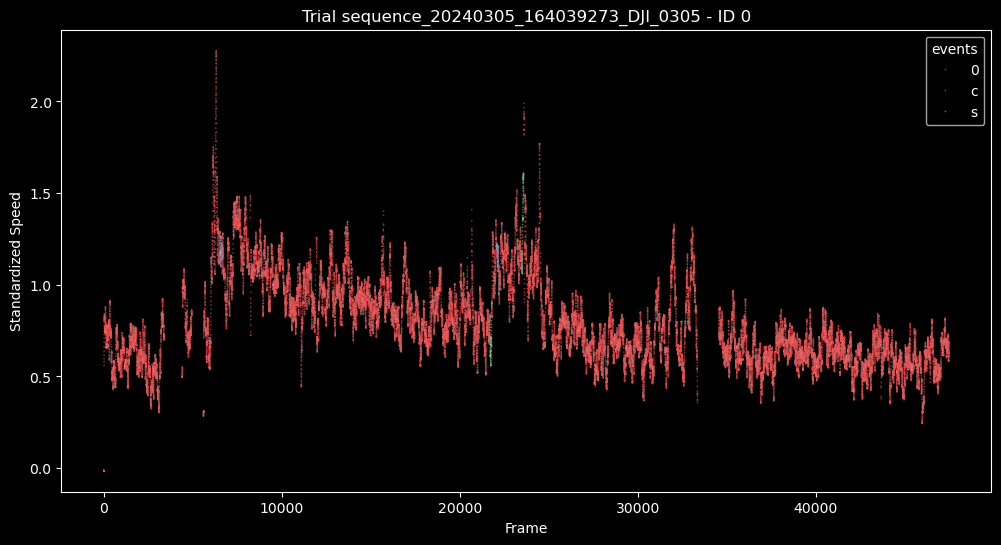

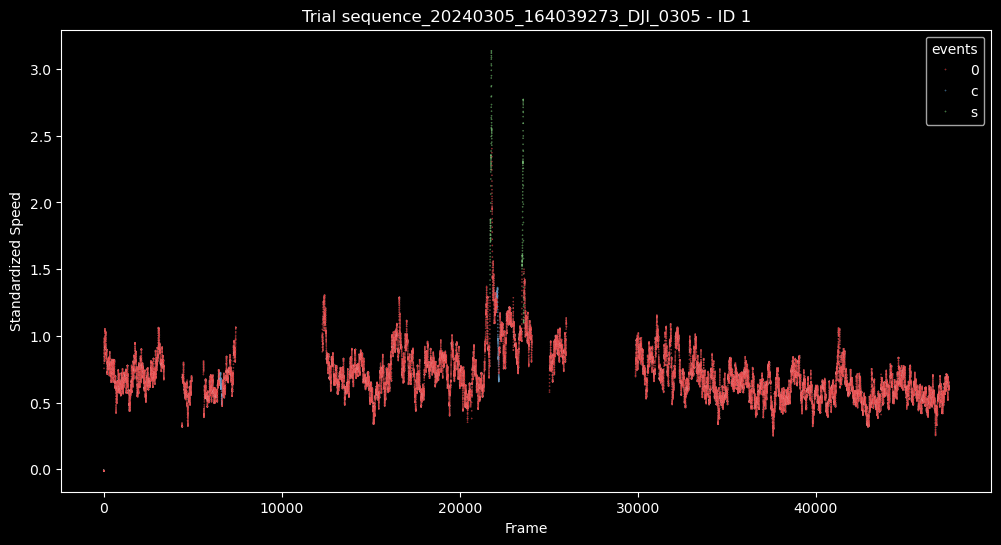

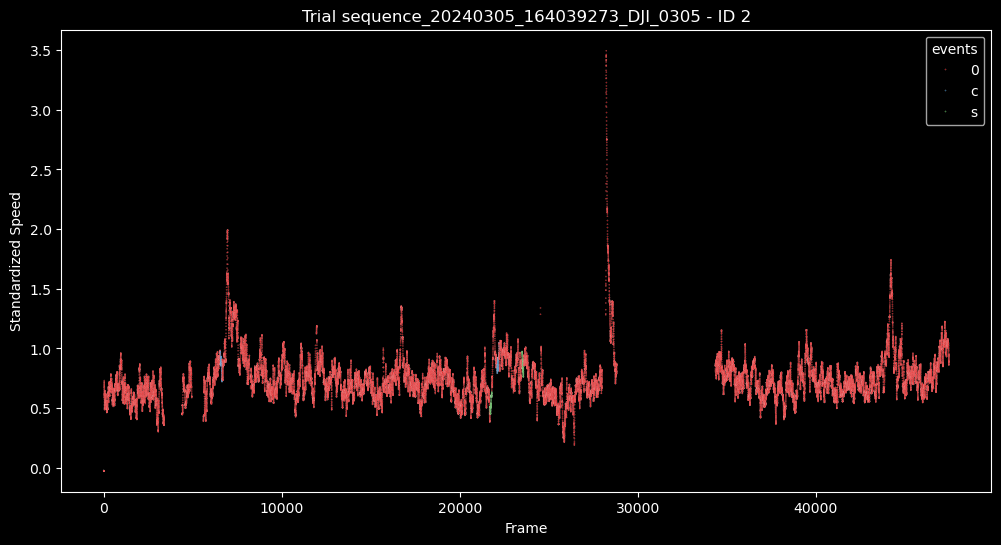

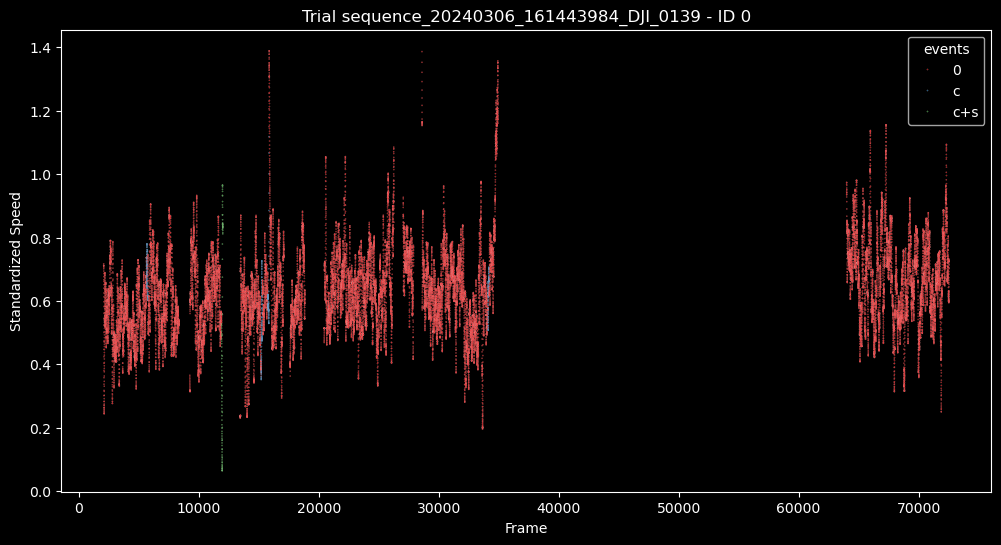

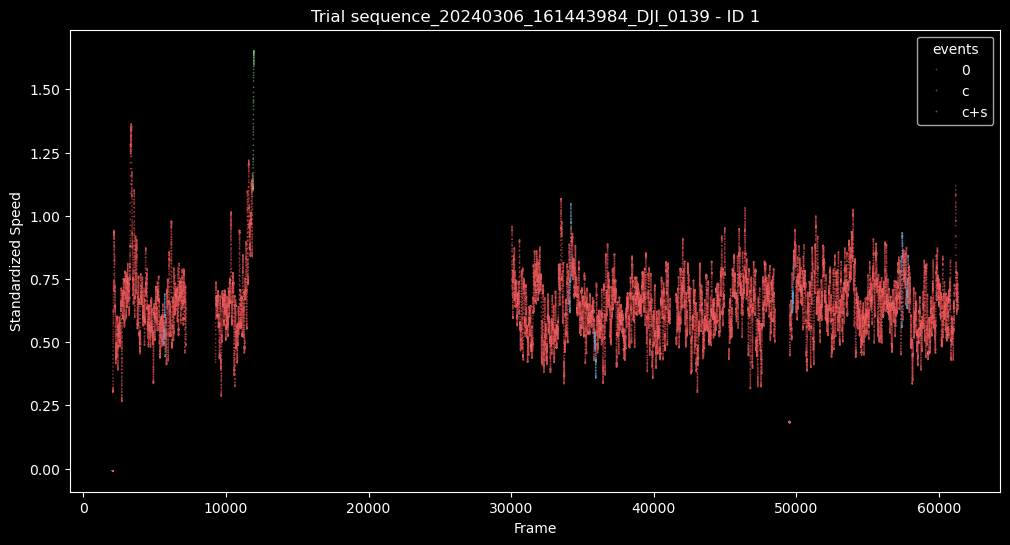

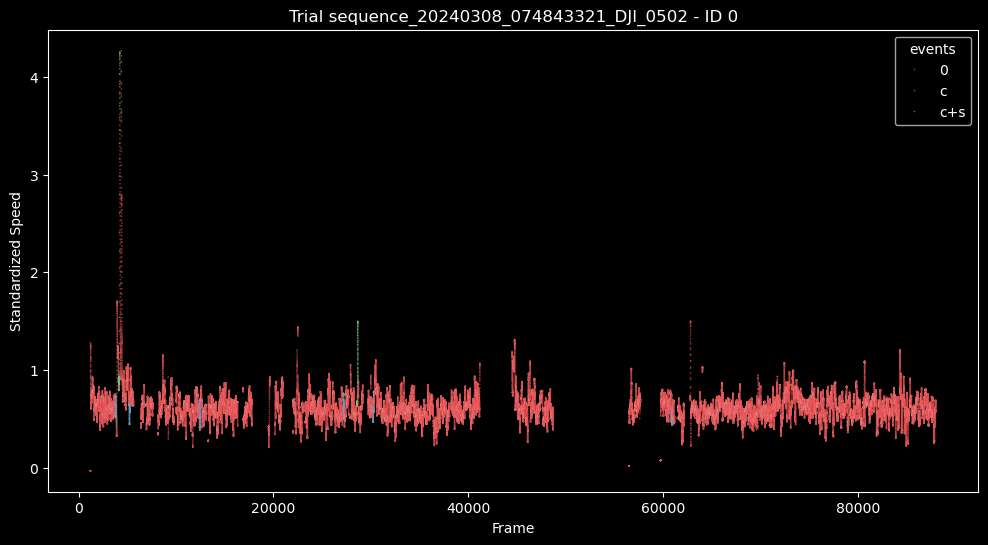

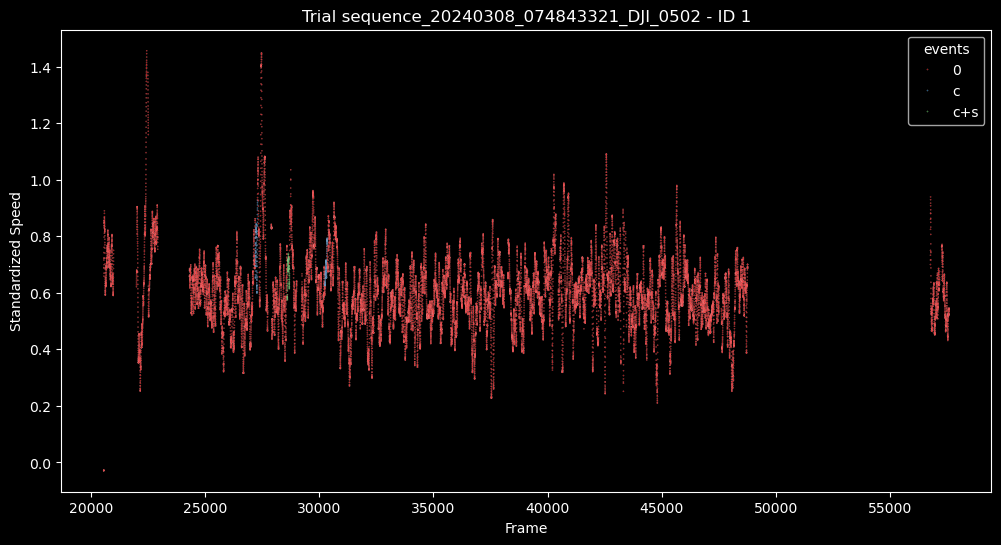

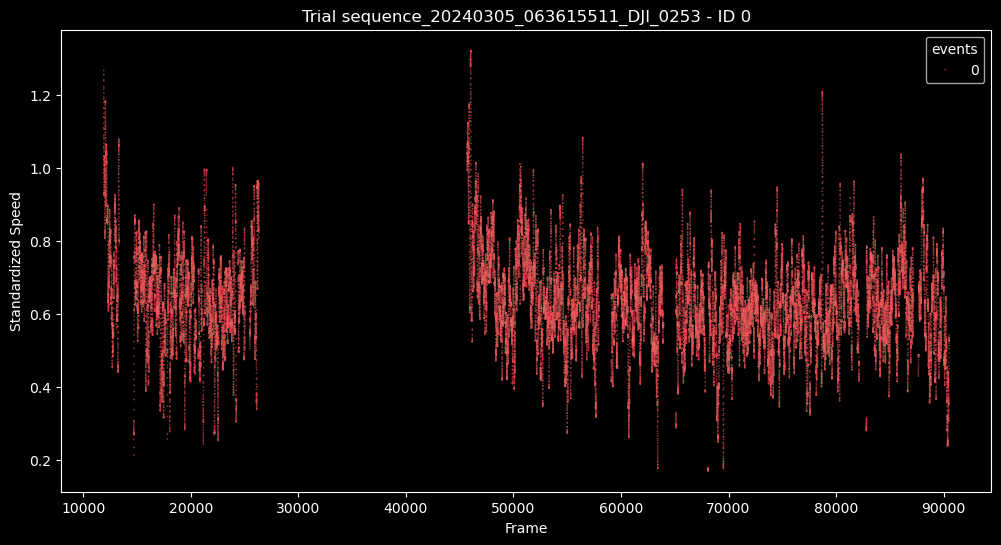

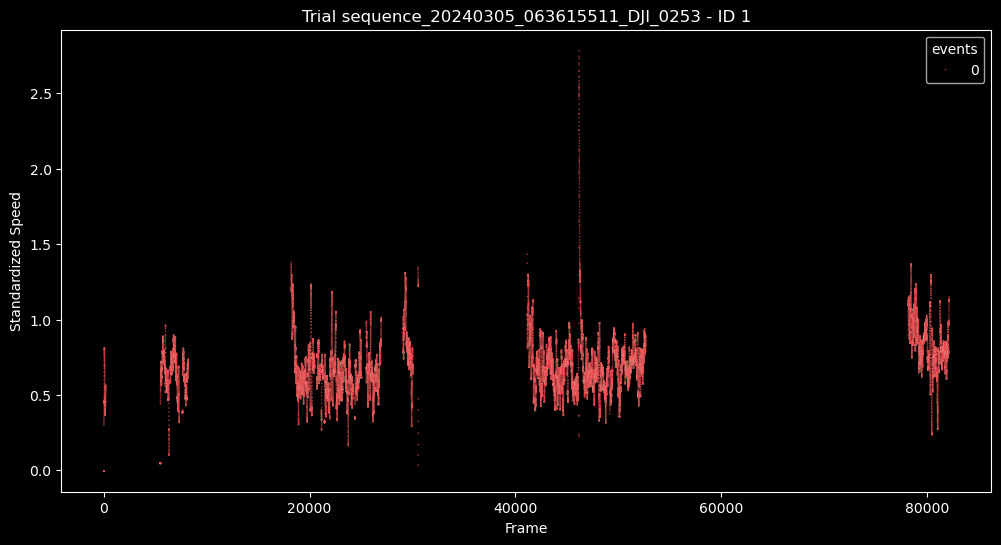

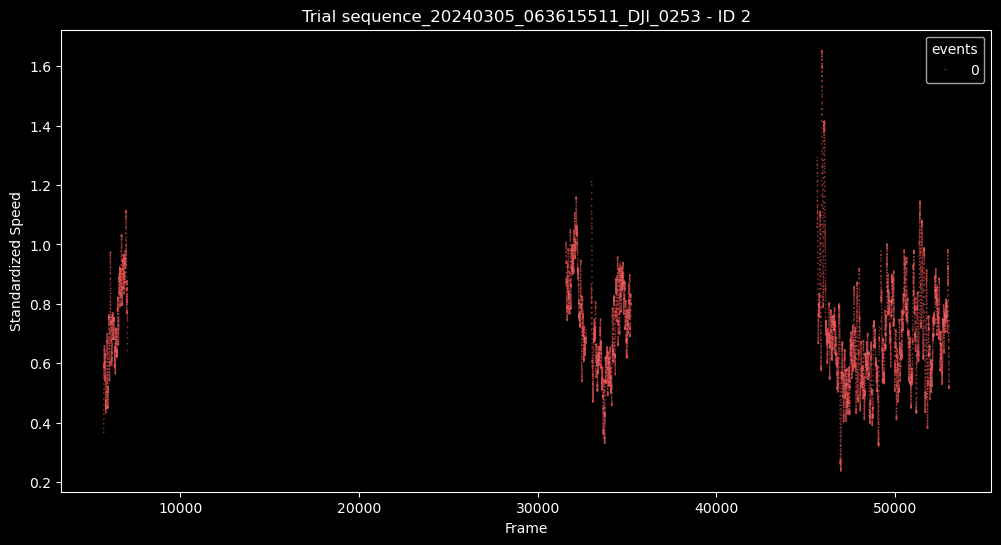

In [47]:
# Loop through each unique Trial
for trial in sharks_df['Trial'].unique():
    trial_data = sharks_df[sharks_df['Trial'] == trial]  # Filter data for the current trial
    
    # Loop through each unique ID in the current trial
    for i in trial_data['ID'].unique():
        plt.figure(figsize=(12, 6))  # Create a new figure for each plot
        
        # Filter the data for the current ID and Trial
        fish_data = trial_data[trial_data['ID'] == i]
        
        # Create the scatter plot with hue based on the 'carangids' column
        sns.scatterplot(x='frame', y='standardized_speed', data=fish_data, hue='events', palette="Set1", s=1, alpha=0.7)
        
        # Set the title and labels
        plt.title(f"Trial {trial} - ID {i}")
        plt.xlabel('Frame')
        plt.ylabel('Standardized Speed')
        
        # Show the plot
        plt.show()
